```
---
title: Summarize GeneOntology annotations
tags: GeneOntology, enrichmentAnalysis, SPARQL, summary
lang: en
version: 0.19
date: 2024-07-26
---
```

In [19]:
import graphviz
import gzip
#import importlib
import IPython
#import json
import math
#import matplotlib.pyplot as plt
#import networkx as nx
#import os
import pandas as pd
#import rdflib
#import rdflib.namespace
import scipy.stats as stats
#import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sparqldataframe
#import sys

In [3]:
goaEndpointURL = "http://localhost:3030/goa/query"
#goEndpointURL = "http://localhost:3030/go/query"
uniprotEndpointURL = "http://sparql.uniprot.org/sparql/"
rdfFormat = "turtle"

#uniprotEndpointURLupdate = uniprotEndpointURL.replace("/query", "/update")
#goEndpointURLupdate = goEndpointURL.replace("/query", "/update")
goaEndpointURLupdate = goaEndpointURL.replace("/query", "/update")

In [4]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>


PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>
PREFIX up:<http://purl.uniprot.org/core/>

PREFIX go: <http://purl.obolibrary.org/obo/GO_>
PREFIX goavoc: <http://bio2rdf.org/goa_vocabulary:>

PREFIX od: <http://univ-rennes.fr/odameron/>

"""

In [5]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    print("Nb results: " + str(len(results["results"]["bindings"])))
    print()
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [6]:
# float_format example: float_format='{:,.2f}'.format
def full_display(x, max_rows=None, max_columns=None, max_colwidth=None, width=2000, float_format=None):
    '''
    Displays a pandas dataframe.
    '''
    with pd.option_context('display.max_rows', max_rows,
                           'display.max_columns', max_columns,
                           'display.max_colwidth', max_colwidth,
                           'display.width', width,
                           'display.float_format', float_format):
        display(x) 

# 1. Setup your environment

## 1.1 Datasets

**TODO:**
- Gene Ontology
- GOA annotations (https://gitlab.com/odameron/goa2rdf)
- (?) ECO Evidence and Conclusion Ontology

![GOA SPARQL endpoint schema](figures/goa.png)

## 1.2 SPARQL endpoint

**TODO:**
- Apache fuseki installation https://gitlab.com/odameron/fusekiInstallationUsage

> ```bash
> ${FUSEKI_HOME}/fuseki-server --update --file ontologies/goa_human.gaf.ttl --file ontologies/go-latest.owl --file ontologies/evidenceCode.owl /goa
> ```

## 1.3 Metrics

Based on:
- ~~GeneOntology 2023-11-15~~
- ~~GOA 2023-11-15~~
- GeneOntology 2024-04-11
- GOA 2024-04-11

In [7]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print("Nb human proteins: " + results["results"]["bindings"][0]["nbProteins"]["value"])

Nb human proteins: 19670


In [8]:
query = """
SELECT (COUNT(DISTINCT ?goIdent) AS ?nbGOterms)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print("Nb GO terms: " + results["results"]["bindings"][0]["nbGOterms"]["value"])

Nb GO terms: 42351


In [9]:
query = """
SELECT ?goRoot ?goLabel (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot ?goLabel
ORDER BY DESC(?nbDescendants)
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
for result in results["results"]["bindings"]:
    print(result["goRoot"]["value"] + "\t" + result["goLabel"]["value"] + "\t" + result["nbDescendants"]["value"])

http://purl.obolibrary.org/obo/GO_0008150	biological_process	27397
http://purl.obolibrary.org/obo/GO_0003674	molecular_function	11180
http://purl.obolibrary.org/obo/GO_0005575	cellular_component	4058


In [10]:
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot             goLabel nbDescendants
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process         27397
1  http://purl.obolibrary.org/obo/GO_0003674  molecular_function         11180
2  http://purl.obolibrary.org/obo/GO_0005575  cellular_component          4058

**Gene Ontology 2023-11-15 (OBSOLETE):**

| goId | goLabel | nb desc. |
|:---|:---|---:|
| go:0008150 | biological process | 27,790 |
| go:0003674 | molecular function | 11,235 |
| go:0005575 | cellular component | 4,061 |
|  |  | **43,086**|

**FIXME:** 42,870 lines in `results/GeneOntology_label.tsv`. Some GO terms belong to multiple branches and/or do not have label?


**Gene Ontology 2024-04-11:**

| goId | goLabel | nb desc. |
|:---|:---|---:|
| go:0008150 | biological process | 27,397 |
| go:0003674 | molecular function | 11,180 |
| go:0005575 | cellular component | 4,058 |
|  |  | **43,086**|

In [11]:
query = """
SELECT ?goRoot ?goLabel (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot ?goLabel
ORDER BY DESC(?nbDescendants)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot             goLabel nbDescendants
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process         27397
1  http://purl.obolibrary.org/obo/GO_0003674  molecular_function         11180
2  http://purl.obolibrary.org/obo/GO_0005575  cellular_component          4058

> **Interpretation:** 
> all the GO terms have a label

In [16]:
query = """
SELECT ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2 (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot1 { go:0005575 go:0003674 }
  VALUES ?goRoot2 { go:0008150 go:0005575 }
  FILTER (str(?goRoot1) < str(?goRoot2))
  ?goRoot1 rdfs:label ?goLabel1 .
  ?goRoot2 rdfs:label ?goLabel2 .
  ?goIdent rdfs:subClassOf* ?goRoot1 .
  ?goIdent rdfs:subClassOf* ?goRoot2 .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2
ORDER BY DESC(?nbDescendants)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot1            goLabel1  \
0  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   

                                     goRoot2            goLabel2 nbDescendants  
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process           283

In [17]:
query = """
SELECT ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2 ?goIdent ?goIdentLabel
WHERE {
  VALUES ?goRoot1 { go:0005575 go:0003674 }
  VALUES ?goRoot2 { go:0008150 go:0005575 }
  FILTER (str(?goRoot1) < str(?goRoot2))
  ?goRoot1 rdfs:label ?goLabel1 .
  ?goRoot2 rdfs:label ?goLabel2 .
  ?goIdent rdfs:subClassOf* ?goRoot1 .
  ?goIdent rdfs:subClassOf* ?goRoot2 .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot1            goLabel1  \
0    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
1    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
2    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
3    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
4    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
..                                         ...                 ...   
279  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
280  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
281  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
282  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
283  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   

                                       goRoot2            goLabel2  \
0    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
1    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
2    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
3    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
4    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
..                                         ...                 ...   
279  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
280  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
281  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
282  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
283  http://purl.obolibrary.org/obo/GO_0008150  biological_process   

                                       goIdent  \
0    http://purl.obolibrary.org/obo/GO_0005254   
1    http://purl.obolibrary.org/obo/GO_0061797   
2    http://purl.obolibrary.org/obo/GO_0072320   
3    http://purl.obolibrary.org/obo/GO_0008068   
4    http://purl.obolibrary.org/obo/GO_0061778   
..                                         ...   
279  http://purl.obolibrary.org/obo/GO_0043398   
280  http://purl.obolibrary.org/obo/GO_0097162   
281  http://purl.obolibrary.org/obo/GO_0035877   
282  http://purl.obolibrary.org/obo/GO_0035501   
283  http://purl.obolibrary.org/obo/GO_0101016   

                                          goIdentLabel  
0                            chloride channel activity  
1                   pH-gated chloride channel activity  
2           volume-sensitive chloride channel activity  
3    extracellularly glutamate-gated chloride chann...  
4              intracellular chloride channel activity  
..                                                 ...  
279                                 HLH domain binding  
280                            MADS box domain binding  
281                      death effector domain binding  
282                                 MH1 domain binding  
283                         FMN-binding domain binding  

[284 rows x 6 columns]

![Ancestors of go:0005254 chloride channel activity](figures/go_hierarchy_0005254_chloride_channel_activity.png)

> **Control:** 43,086-283=42,803
>
> yet, 42,870 lines in `results/GeneOntology_label.tsv`.
> Some GO terms have multiple labels?

In [22]:
query = """
SELECT ?goIdent (COUNT(DISTINCT ?goIdentLabel) AS ?nbLabels)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
HAVING (COUNT(DISTINCT ?goIdentLabel) > 1)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent nbLabels
0   http://purl.obolibrary.org/obo/GO_0005216        2
1   http://purl.obolibrary.org/obo/GO_0015075        2
2   http://purl.obolibrary.org/obo/GO_0043603        2
3   http://purl.obolibrary.org/obo/GO_0040033        2
4   http://purl.obolibrary.org/obo/GO_0040030        2
..                                        ...      ...
62  http://purl.obolibrary.org/obo/GO_0016441        2
63  http://purl.obolibrary.org/obo/GO_0060548        2
64  http://purl.obolibrary.org/obo/GO_0051270        2
65  http://purl.obolibrary.org/obo/GO_0051272        2
66  http://purl.obolibrary.org/obo/GO_0051271        2

[67 rows x 2 columns]

In [21]:
query = """
SELECT DISTINCT ?goIdent ?goIdentLabel ?goIdentLabel2
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  ?goIdent rdfs:label ?goIdentLabel2 .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER (?goIdentLabel != ?goIdentLabel2)
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0    http://purl.obolibrary.org/obo/GO_0006811   
1    http://purl.obolibrary.org/obo/GO_0006811   
2    http://purl.obolibrary.org/obo/GO_0006820   
3    http://purl.obolibrary.org/obo/GO_0006820   
4    http://purl.obolibrary.org/obo/GO_0034220   
..                                         ...   
129  http://purl.obolibrary.org/obo/GO_0015075   
130  http://purl.obolibrary.org/obo/GO_0004520   
131  http://purl.obolibrary.org/obo/GO_0004520   
132  http://purl.obolibrary.org/obo/GO_0004536   
133  http://purl.obolibrary.org/obo/GO_0004536   

                                          goIdentLabel  \
0                                        ion transport   
1                             monoatomic ion transport   
2                                      anion transport   
3                           monoatomic anion transport   
4                          ion transmembrane transport   
..                                                 ...   
129  monoatomic ion transmembrane transporter activity   
130                          DNA endonuclease activity   
131                     endodeoxyribonuclease activity   
132                              DNA nuclease activity   
133                         deoxyribonuclease activity   

                              goIdentLabel2  
0                  monoatomic ion transport  
1                             ion transport  
2                monoatomic anion transport  
3                           anion transport  
4    monoatomic ion transmembrane transport  
..                                      ...  
129  ion transmembrane transporter activity  
130          endodeoxyribonuclease activity  
131               DNA endonuclease activity  
132              deoxyribonuclease activity  
133                   DNA nuclease activity  

[134 rows x 3 columns]

> **Control:** 43,086-283=42,803
>
> yet, 42,870 lines in `results/GeneOntology_label.tsv`.
> 42,870-67=42,803

> **Synthesis:** 42,803 distinct GO terms, 67 of which have multiple labels, and 283 of which belong to multiple branches

In [40]:
query = """
SELECT DISTINCT ?goIdent ?goIdentLabel
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0      http://purl.obolibrary.org/obo/GO_0008150   
1      http://purl.obolibrary.org/obo/GO_0051179   
2      http://purl.obolibrary.org/obo/GO_0031503   
3      http://purl.obolibrary.org/obo/GO_0034630   
4      http://purl.obolibrary.org/obo/GO_1990953   
...                                          ...   
42865  http://purl.obolibrary.org/obo/GO_0030281   
42866  http://purl.obolibrary.org/obo/GO_0140223   
42867  http://purl.obolibrary.org/obo/GO_0001181   
42868  http://purl.obolibrary.org/obo/GO_0016251   
42869  http://purl.obolibrary.org/obo/GO_0000995   

                                            goIdentLabel  
0                                     biological_process  
1                                           localization  
2                protein-containing complex localization  
3                              RITS complex localization  
4                               intramanchette transport  
...                                                  ...  
42865      structural constituent of cutaneous appendage  
42866   general transcription initiation factor activity  
42867  RNA polymerase I general transcription initiat...  
42868  RNA polymerase II general transcription initia...  
42869  RNA polymerase III general transcription initi...  

[42870 rows x 2 columns]

In [44]:
query = """
SELECT DISTINCT ?goIdent (SAMPLE(?goIdentLabel) AS ?gLabel)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0      http://purl.obolibrary.org/obo/GO_1903186   
1      http://purl.obolibrary.org/obo/GO_0045160   
2      http://purl.obolibrary.org/obo/GO_1905581   
3      http://purl.obolibrary.org/obo/GO_0015047   
4      http://purl.obolibrary.org/obo/GO_0061953   
...                                          ...   
42798  http://purl.obolibrary.org/obo/GO_0005687   
42799  http://purl.obolibrary.org/obo/GO_0042887   
42800  http://purl.obolibrary.org/obo/GO_0050074   
42801  http://purl.obolibrary.org/obo/GO_0001727   
42802  http://purl.obolibrary.org/obo/GO_0102089   

                                                  gLabel  
0                           regulation of vitellogenesis  
1                                       myosin I complex  
2      positive regulation of low-density lipoprotein...  
3                 NADPH-cytochrome-c2 reductase activity  
4          mRNA (adenine-N1-)-methyltransferase activity  
...                                                  ...  
42798                                           U4 snRNP  
42799           amide transmembrane transporter activity  
42800                         malate-CoA ligase activity  
42801                              lipid kinase activity  
42802                dehydroscoulerine synthase activity  

[42803 rows x 2 columns]

## 1.4 Proportions of proteins and GO terms involved in annotations

In [12]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbproteins = results["results"]["bindings"][0]["nbProteins"]["value"]
print("Nb human proteins: " + totalNbproteins)

Nb human proteins: 19670


In [13]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbproteinsAnnotated = results["results"]["bindings"][0]["nbProteins"]["value"]
print("Nb human proteins annotated by >=1 GO term: " + totalNbproteinsAnnotated)

Nb human proteins annotated by >=1 GO term: 19670


In [14]:
query = """
SELECT (COUNT(DISTINCT ?goIdent) AS ?nbGOterms)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbgoTerms = results["results"]["bindings"][0]["nbGOterms"]["value"]
print("Nb GO terms: " + totalNbgoTerms)

Nb GO terms: 42351


In [15]:
query = """
SELECT (COUNT(DISTINCT ?annotation) AS ?nbAnnotations)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbgoTermsAnnotated = results["results"]["bindings"][0]["nbAnnotations"]["value"]
print("Nb GO terms annotating >= protein: " + totalNbgoTermsAnnotated)

Nb GO terms annotating >= protein: 22100


> **Synthesis:**
> For *Homo sapiens:*
> - ~~all 19,635 proteins are annotated by >= 1 GO term~~
> - ~~among 42,803 GO terms, 22,073 (52%) annotate directly or indirectly >=1 protein~~
> - all 19,670 proteins are annotated by >= 1 GO term
> - among 42,351 GO terms, 22,100 (52%) annotate directly or indirectly >=1 protein

> **TODO:**
> compute separately for BP, CC, MF

# 2. Annotations for all the proteins (run this if you need to generate or update the files, otherwise proceed to section 3)

## 2.1 GO terms and labels

In [21]:
#with open("results/GeneOntology_label.tsv", "w") as destFile :
with gzip.open("results/GeneOntology_label.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?goIdent (SAMPLE(?goIdentLabel) AS ?goLabel)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["goIdent"]["value"] + "\t" + result["goLabel"]["value"] + "\n")

## 2.2 Human proteins and labels

In [24]:
#with open("results/Proteins_label.tsv", "w") as destFile :
with gzip.open("results/Proteins_label.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?protein ?proteinLabel
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein rdfs:label ?proteinLabel .
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["protein"]["value"] + "\t" + result["proteinLabel"]["value"] + "\n")

## 2.2 Annotations for all human proteins

In [25]:
#with open("results/Proteins_annotations.tsv", "w") as destFile :
with gzip.open("results/Proteins_annotations.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?protein ?annotation
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["protein"]["value"] + "\t" + result["annotation"]["value"] + "\n")

# 3. Load data

In [26]:
dfGOlabel = pd.read_csv("results/GeneOntology_label.tsv.gz", delimiter='\t', names=["goID", "goLabel"], index_col="goID")
dfGOlabel.drop_duplicates(subset=None, keep='first', inplace=True)
dfGOlabel.head()

goLabel
goID                                                                                        
http://purl.obolibrary.org/obo/GO_0070549  siRNA-mediated gene silencing by inhibition of...
http://purl.obolibrary.org/obo/GO_0070542                             response to fatty acid
http://purl.obolibrary.org/obo/GO_0070541                           response to platinum ion
http://purl.obolibrary.org/obo/GO_0070543                          response to linoleic acid
http://purl.obolibrary.org/obo/GO_0070546          L-phenylalanine aminotransferase activity

In [27]:
dfProteinGO = pd.read_csv("results/Proteins_annotations.tsv.gz", delimiter='\t', names=["uniprotID", "goID"])
dfProteinGO.drop_duplicates(subset=None, keep='first', inplace=True)
dfProteinGO.head()

uniprotID  \
0  http://purl.uniprot.org/uniprot/Q12774   
1  http://purl.uniprot.org/uniprot/Q12774   
2  http://purl.uniprot.org/uniprot/Q12774   
3  http://purl.uniprot.org/uniprot/Q12774   
4  http://purl.uniprot.org/uniprot/Q12774   

                                        goID  
0  http://purl.obolibrary.org/obo/GO_0002408  
1  http://purl.obolibrary.org/obo/GO_0002407  
2  http://purl.obolibrary.org/obo/GO_0030595  
3  http://purl.obolibrary.org/obo/GO_0060326  
4  http://purl.obolibrary.org/obo/GO_0006935

# 4. Compute frequencies

## 4.1 consistency checks between the results of the metrics computed with SPARQL and the dataframe

In [28]:
referenceGO = dfProteinGO.goID.unique().tolist()
print("Nb GO terms annotating >=1 protein: " + str(len(referenceGO)))

Nb GO terms annotating >=1 protein: 22100


In [29]:
referenceProteins = dfProteinGO.uniprotID.unique().tolist()
print("Nb proteins annotated by >=1 GO term: " + str(len(referenceProteins)))

Nb proteins annotated by >=1 GO term: 19670


## 4.2 frequencies

### 4.2.1 reference set

Here we assume that the reference set is the set of UniProt human proteins annotated by at least 1 GO term.

In [30]:
print(str(dfProteinGO["goID"].value_counts()))

http://purl.obolibrary.org/obo/GO_0005575    18993
http://purl.obolibrary.org/obo/GO_0110165    18635
http://purl.obolibrary.org/obo/GO_0003674    18265
http://purl.obolibrary.org/obo/GO_0008150    17842
http://purl.obolibrary.org/obo/GO_0005488    16479
                                             ...  
http://purl.obolibrary.org/obo/GO_0030586        1
http://purl.obolibrary.org/obo/GO_0035397        1
http://purl.obolibrary.org/obo/GO_0021998        1
http://purl.obolibrary.org/obo/GO_1901845        1
http://purl.obolibrary.org/obo/GO_2000793        1
Name: goID, Length: 22100, dtype: int64


In [31]:
print(str(dfProteinGO["uniprotID"].value_counts()))

http://purl.uniprot.org/uniprot/P01137    933
http://purl.uniprot.org/uniprot/P01375    845
http://purl.uniprot.org/uniprot/P31749    753
http://purl.uniprot.org/uniprot/P12931    717
http://purl.uniprot.org/uniprot/P46531    709
                                         ... 
http://purl.uniprot.org/uniprot/Q14602      2
http://purl.uniprot.org/uniprot/Q8IYM0      2
http://purl.uniprot.org/uniprot/O76042      2
http://purl.uniprot.org/uniprot/Q8TE82      2
http://purl.uniprot.org/uniprot/Q9GZU0      2
Name: uniprotID, Length: 19670, dtype: int64


In [32]:
nbUniprotReference = len(dfProteinGO["uniprotID"].unique())
nbUniprotReference

19670

In [33]:
occurrencesGOreference = dfProteinGO["goID"].value_counts()
occurrencesGOreference.rename("nbUniprotReference", inplace=True)
occurrencesGOreference = occurrencesGOreference.to_frame()
occurrencesGOreference

nbUniprotReference
http://purl.obolibrary.org/obo/GO_0005575               18993
http://purl.obolibrary.org/obo/GO_0110165               18635
http://purl.obolibrary.org/obo/GO_0003674               18265
http://purl.obolibrary.org/obo/GO_0008150               17842
http://purl.obolibrary.org/obo/GO_0005488               16479
...                                                       ...
http://purl.obolibrary.org/obo/GO_0030586                   1
http://purl.obolibrary.org/obo/GO_0035397                   1
http://purl.obolibrary.org/obo/GO_0021998                   1
http://purl.obolibrary.org/obo/GO_1901845                   1
http://purl.obolibrary.org/obo/GO_2000793                   1

[22100 rows x 1 columns]

In [34]:
occurrencesGOreference = occurrencesGOreference.merge(dfGOlabel, left_index=True, right_index=True)
occurrencesGOreference

nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0005575               18993   
http://purl.obolibrary.org/obo/GO_0110165               18635   
http://purl.obolibrary.org/obo/GO_0003674               18265   
http://purl.obolibrary.org/obo/GO_0008150               17842   
http://purl.obolibrary.org/obo/GO_0005488               16479   
...                                                       ...   
http://purl.obolibrary.org/obo/GO_0030586                   1   
http://purl.obolibrary.org/obo/GO_0035397                   1   
http://purl.obolibrary.org/obo/GO_0021998                   1   
http://purl.obolibrary.org/obo/GO_1901845                   1   
http://purl.obolibrary.org/obo/GO_2000793                   1   

                                                                                     goLabel  
http://purl.obolibrary.org/obo/GO_0005575                                 cellular_component  
http://purl.obolibrary.org/obo/GO_0110165                         cellular anatomical entity  
http://purl.obolibrary.org/obo/GO_0003674                                 molecular_function  
http://purl.obolibrary.org/obo/GO_0008150                                 biological_process  
http://purl.obolibrary.org/obo/GO_0005488                                            binding  
...                                                                                      ...  
http://purl.obolibrary.org/obo/GO_0030586           [methionine synthase] reductase activity  
http://purl.obolibrary.org/obo/GO_0035397  helper T cell enhancement of adaptive immune r...  
http://purl.obolibrary.org/obo/GO_0021998          neural plate mediolateral regionalization  
http://purl.obolibrary.org/obo/GO_1901845  negative regulation of cell communication by e...  
http://purl.obolibrary.org/obo/GO_2000793  cell proliferation involved in heart valve dev...  

[22100 rows x 2 columns]

In [35]:
occurrencesGOreference['IC'] = occurrencesGOreference['nbUniprotReference'].map(lambda x: math.log(nbUniprotReference/x))
occurrencesGOreference

nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0005575               18993   
http://purl.obolibrary.org/obo/GO_0110165               18635   
http://purl.obolibrary.org/obo/GO_0003674               18265   
http://purl.obolibrary.org/obo/GO_0008150               17842   
http://purl.obolibrary.org/obo/GO_0005488               16479   
...                                                       ...   
http://purl.obolibrary.org/obo/GO_0030586                   1   
http://purl.obolibrary.org/obo/GO_0035397                   1   
http://purl.obolibrary.org/obo/GO_0021998                   1   
http://purl.obolibrary.org/obo/GO_1901845                   1   
http://purl.obolibrary.org/obo/GO_2000793                   1   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0005575                                 cellular_component   
http://purl.obolibrary.org/obo/GO_0110165                         cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0003674                                 molecular_function   
http://purl.obolibrary.org/obo/GO_0008150                                 biological_process   
http://purl.obolibrary.org/obo/GO_0005488                                            binding   
...                                                                                      ...   
http://purl.obolibrary.org/obo/GO_0030586           [methionine synthase] reductase activity   
http://purl.obolibrary.org/obo/GO_0035397  helper T cell enhancement of adaptive immune r...   
http://purl.obolibrary.org/obo/GO_0021998          neural plate mediolateral regionalization   
http://purl.obolibrary.org/obo/GO_1901845  negative regulation of cell communication by e...   
http://purl.obolibrary.org/obo/GO_2000793  cell proliferation involved in heart valve dev...   

                                                 IC  
http://purl.obolibrary.org/obo/GO_0005575  0.035024  
http://purl.obolibrary.org/obo/GO_0110165  0.054053  
http://purl.obolibrary.org/obo/GO_0003674  0.074108  
http://purl.obolibrary.org/obo/GO_0008150  0.097539  
http://purl.obolibrary.org/obo/GO_0005488  0.177008  
...                                             ...  
http://purl.obolibrary.org/obo/GO_0030586  9.886850  
http://purl.obolibrary.org/obo/GO_0035397  9.886850  
http://purl.obolibrary.org/obo/GO_0021998  9.886850  
http://purl.obolibrary.org/obo/GO_1901845  9.886850  
http://purl.obolibrary.org/obo/GO_2000793  9.886850  

[22100 rows x 3 columns]

In [51]:
occurrencesGOreference.to_csv('results/occurrencesGOreference.tsv.gz', sep='\t', header=True, index=True, compression='gzip')

### 4.2.2 set1

**DAVID**
![Set1: DAVID](./results/set1-david.png)

**Revigo**

![Set1: Revigo (scatterplot)](./results/set1-revigo-scatterplot.png)

![Set1: Revigo (treemap)](./results/set1-revigo-treemap.png)

![GeneOntology hierarchy of "heme A biosynthetic process" GO:0006784](./data/GO-heme_A_biosynthetic_process.png)

In [38]:
#dfSet1 = pd.read_csv("data/geneSet_1.txt", delimiter='\t', names=["uniprotID"], index_col=0)
#dfSet1

dfSet1 = pd.read_csv("data/geneSet_1.txt", delimiter='\t', names=["uniprotCURIE"])
dfSet1
dfSet1["uniprotID"] = dfSet1["uniprotCURIE"].str.replace("uniprot:", "http://purl.uniprot.org/uniprot/")
dfSet1 = dfSet1["uniprotID"].to_frame()
dfSet1.set_index("uniprotID", inplace=True)
dfSet1

Empty DataFrame
Columns: []
Index: [http://purl.uniprot.org/uniprot/P06132, http://purl.uniprot.org/uniprot/P08397, http://purl.uniprot.org/uniprot/P10746, http://purl.uniprot.org/uniprot/P13196, http://purl.uniprot.org/uniprot/P13716, http://purl.uniprot.org/uniprot/P22557, http://purl.uniprot.org/uniprot/P22830, http://purl.uniprot.org/uniprot/P36551, http://purl.uniprot.org/uniprot/P50336, http://purl.uniprot.org/uniprot/Q12887, http://purl.uniprot.org/uniprot/Q7KZN9]

In [39]:
nbUniprotSet1 = len(dfSet1)
nbUniprotSet1

11

In [40]:
dfProteinGO

uniprotID  \
0        http://purl.uniprot.org/uniprot/Q12774   
1        http://purl.uniprot.org/uniprot/Q12774   
2        http://purl.uniprot.org/uniprot/Q12774   
3        http://purl.uniprot.org/uniprot/Q12774   
4        http://purl.uniprot.org/uniprot/Q12774   
...                                         ...   
1537402  http://purl.uniprot.org/uniprot/Q6UWF3   
1537403  http://purl.uniprot.org/uniprot/Q6UWF3   
1537404  http://purl.uniprot.org/uniprot/Q6UWF3   
1537405  http://purl.uniprot.org/uniprot/Q6UWF3   
1537406  http://purl.uniprot.org/uniprot/Q6UWF3   

                                              goID  
0        http://purl.obolibrary.org/obo/GO_0002408  
1        http://purl.obolibrary.org/obo/GO_0002407  
2        http://purl.obolibrary.org/obo/GO_0030595  
3        http://purl.obolibrary.org/obo/GO_0060326  
4        http://purl.obolibrary.org/obo/GO_0006935  
...                                            ...  
1537402  http://purl.obolibrary.org/obo/GO_0032991  
1537403  http://purl.obolibrary.org/obo/GO_0005515  
1537404  http://purl.obolibrary.org/obo/GO_0005488  
1537405  http://purl.obolibrary.org/obo/GO_0003674  
1537406  http://purl.obolibrary.org/obo/GO_0060090  

[1537407 rows x 2 columns]

In [41]:
dfProteinGOSet1 = dfProteinGO.merge(dfSet1, left_on="uniprotID", right_on="uniprotID")
dfProteinGOSet1

uniprotID  \
0     http://purl.uniprot.org/uniprot/P50336   
1     http://purl.uniprot.org/uniprot/P50336   
2     http://purl.uniprot.org/uniprot/P50336   
3     http://purl.uniprot.org/uniprot/P50336   
4     http://purl.uniprot.org/uniprot/P50336   
...                                      ...   
1052  http://purl.uniprot.org/uniprot/P22830   
1053  http://purl.uniprot.org/uniprot/P22830   
1054  http://purl.uniprot.org/uniprot/P22830   
1055  http://purl.uniprot.org/uniprot/P22830   
1056  http://purl.uniprot.org/uniprot/P22830   

                                           goID  
0     http://purl.obolibrary.org/obo/GO_0006784  
1     http://purl.obolibrary.org/obo/GO_0006783  
2     http://purl.obolibrary.org/obo/GO_0046148  
3     http://purl.obolibrary.org/obo/GO_0042440  
4     http://purl.obolibrary.org/obo/GO_0008152  
...                                         ...  
1052  http://purl.obolibrary.org/obo/GO_0051537  
1053  http://purl.obolibrary.org/obo/GO_0051536  
1054  http://purl.obolibrary.org/obo/GO_0051540  
1055  http://purl.obolibrary.org/obo/GO_0042803  
1056  http://purl.obolibrary.org/obo/GO_0046983  

[1057 rows x 2 columns]

In [42]:
len(dfProteinGOSet1['uniprotID'].unique())

11

In [43]:
len(dfProteinGOSet1['goID'].unique())

401

In [44]:
occurrencesGOset1 = dfProteinGOSet1["goID"].value_counts()
occurrencesGOset1.rename("nbUniprotSet1", inplace=True)
#occurrencesGOset1 = occurrencesGOreference.to_frame()
occurrencesGOset1

http://purl.obolibrary.org/obo/GO_0046148    11
http://purl.obolibrary.org/obo/GO_0006783    11
http://purl.obolibrary.org/obo/GO_1901576    11
http://purl.obolibrary.org/obo/GO_0003674    11
http://purl.obolibrary.org/obo/GO_0044237    11
                                             ..
http://purl.obolibrary.org/obo/GO_0006979     1
http://purl.obolibrary.org/obo/GO_0071345     1
http://purl.obolibrary.org/obo/GO_0046689     1
http://purl.obolibrary.org/obo/GO_0010043     1
http://purl.obolibrary.org/obo/GO_0044255     1
Name: nbUniprotSet1, Length: 401, dtype: int64

In [45]:
nbGOSet1 = len(dfProteinGOSet1["goID"].unique())
nbGOSet1

401

In [46]:
occurrencesGO = pd.merge(occurrencesGOset1, occurrencesGOreference, right_index = True, left_index = True)
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046148             11                  43   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_1901576             11                2367   
http://purl.obolibrary.org/obo/GO_0003674             11               18265   
http://purl.obolibrary.org/obo/GO_0044237             11                5673   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0006979              1                 359   
http://purl.obolibrary.org/obo/GO_0071345              1                 424   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   
http://purl.obolibrary.org/obo/GO_0010043              1                  50   
http://purl.obolibrary.org/obo/GO_0044255              1                 927   

                                                                          goLabel  \
http://purl.obolibrary.org/obo/GO_0046148            pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783               heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901576  organic substance biosynthetic process   
http://purl.obolibrary.org/obo/GO_0003674                      molecular_function   
http://purl.obolibrary.org/obo/GO_0044237              cellular metabolic process   
...                                                                           ...   
http://purl.obolibrary.org/obo/GO_0006979            response to oxidative stress   
http://purl.obolibrary.org/obo/GO_0071345  cellular response to cytokine stimulus   
http://purl.obolibrary.org/obo/GO_0046689                 response to mercury ion   
http://purl.obolibrary.org/obo/GO_0010043                    response to zinc ion   
http://purl.obolibrary.org/obo/GO_0044255        cellular lipid metabolic process   

                                                 IC  
http://purl.obolibrary.org/obo/GO_0046148  6.125650  
http://purl.obolibrary.org/obo/GO_0006783  6.667974  
http://purl.obolibrary.org/obo/GO_1901576  2.117471  
http://purl.obolibrary.org/obo/GO_0003674  0.074108  
http://purl.obolibrary.org/obo/GO_0044237  1.243377  
...                                             ...  
http://purl.obolibrary.org/obo/GO_0006979  4.003528  
http://purl.obolibrary.org/obo/GO_0071345  3.837116  
http://purl.obolibrary.org/obo/GO_0046689  7.689625  
http://purl.obolibrary.org/obo/GO_0010043  5.974827  
http://purl.obolibrary.org/obo/GO_0044255  3.054896  

[401 rows x 4 columns]

In [47]:
occurrencesGO["ICcoverage"] = occurrencesGO["IC"] * occurrencesGO["nbUniprotSet1"]
#occurrencesGO.sort_values(by="IC", ascending=False)
occurrencesGO.sort_values(by="ICcoverage", ascending=False)

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0065007              2               12072   
http://purl.obolibrary.org/obo/GO_0003674             11               18265   
http://purl.obolibrary.org/obo/GO_0110165             11               18635   
http://purl.obolibrary.org/obo/GO_0050794              1               11160   
http://purl.obolibrary.org/obo/GO_0005575             11               18993   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0046160                           heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784                        heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006779  porphyrin-containing compound biosynthetic pro...   
http://purl.obolibrary.org/obo/GO_0033014                  tetrapyrrole biosynthetic process   
...                                                                                      ...   
http://purl.obolibrary.org/obo/GO_0065007                              biological regulation   
http://purl.obolibrary.org/obo/GO_0003674                                 molecular_function   
http://purl.obolibrary.org/obo/GO_0110165                         cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0050794                     regulation of cellular process   
http://purl.obolibrary.org/obo/GO_0005575                                 cellular_component   

                                                 IC  ICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  7.584265   75.842648  
http://purl.obolibrary.org/obo/GO_0006784  7.584265   75.842648  
http://purl.obolibrary.org/obo/GO_0006783  6.667974   73.347715  
http://purl.obolibrary.org/obo/GO_0006779  6.519554   71.715095  
http://purl.obolibrary.org/obo/GO_0033014  6.519554   71.715095  
...                                             ...         ...  
http://purl.obolibrary.org/obo/GO_0065007  0.488206    0.976412  
http://purl.obolibrary.org/obo/GO_0003674  0.074108    0.815188  
http://purl.obolibrary.org/obo/GO_0110165  0.054053    0.594584  
http://purl.obolibrary.org/obo/GO_0050794  0.566759    0.566759  
http://purl.obolibrary.org/obo/GO_0005575  0.035024    0.385266  

[401 rows x 5 columns]

In [48]:
occurrencesGO["pValue"] = stats.hypergeom.sf(occurrencesGO['nbUniprotSet1']-1, nbUniprotReference, occurrencesGO['nbUniprotReference'], nbUniprotSet1)
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046148             11                  43   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_1901576             11                2367   
http://purl.obolibrary.org/obo/GO_0003674             11               18265   
http://purl.obolibrary.org/obo/GO_0044237             11                5673   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0006979              1                 359   
http://purl.obolibrary.org/obo/GO_0071345              1                 424   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   
http://purl.obolibrary.org/obo/GO_0010043              1                  50   
http://purl.obolibrary.org/obo/GO_0044255              1                 927   

                                                                          goLabel  \
http://purl.obolibrary.org/obo/GO_0046148            pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783               heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901576  organic substance biosynthetic process   
http://purl.obolibrary.org/obo/GO_0003674                      molecular_function   
http://purl.obolibrary.org/obo/GO_0044237              cellular metabolic process   
...                                                                           ...   
http://purl.obolibrary.org/obo/GO_0006979            response to oxidative stress   
http://purl.obolibrary.org/obo/GO_0071345  cellular response to cytokine stimulus   
http://purl.obolibrary.org/obo/GO_0046689                 response to mercury ion   
http://purl.obolibrary.org/obo/GO_0010043                    response to zinc ion   
http://purl.obolibrary.org/obo/GO_0044255        cellular lipid metabolic process   

                                                 IC  ICcoverage        pValue  
http://purl.obolibrary.org/obo/GO_0046148  6.125650   67.382148  1.350024e-30  
http://purl.obolibrary.org/obo/GO_0006783  6.667974   73.347715  1.046174e-33  
http://purl.obolibrary.org/obo/GO_1901576  2.117471   23.292184  7.506563e-11  
http://purl.obolibrary.org/obo/GO_0003674  0.074108    0.815188  4.424610e-01  
http://purl.obolibrary.org/obo/GO_0044237  1.243377   13.677142  1.140497e-06  
...                                             ...         ...           ...  
http://purl.obolibrary.org/obo/GO_0006979  4.003528    4.003528  1.834517e-01  
http://purl.obolibrary.org/obo/GO_0071345  3.837116    3.837116  2.131887e-01  
http://purl.obolibrary.org/obo/GO_0046689  7.689625    7.689625  5.022821e-03  
http://purl.obolibrary.org/obo/GO_0010043  5.974827    5.974827  2.761561e-02  
http://purl.obolibrary.org/obo/GO_0044255  3.054896    3.054896  4.120747e-01  

[401 rows x 6 columns]

In [49]:
#occurrencesGO["adjPvalue"] = stats.false_discovery_control(occurrencesGO["pValue"])
occurrencesGO["bonferroni"] = occurrencesGO["pValue"] * nbGOSet1
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046148             11                  43   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_1901576             11                2367   
http://purl.obolibrary.org/obo/GO_0003674             11               18265   
http://purl.obolibrary.org/obo/GO_0044237             11                5673   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0006979              1                 359   
http://purl.obolibrary.org/obo/GO_0071345              1                 424   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   
http://purl.obolibrary.org/obo/GO_0010043              1                  50   
http://purl.obolibrary.org/obo/GO_0044255              1                 927   

                                                                          goLabel  \
http://purl.obolibrary.org/obo/GO_0046148            pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783               heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901576  organic substance biosynthetic process   
http://purl.obolibrary.org/obo/GO_0003674                      molecular_function   
http://purl.obolibrary.org/obo/GO_0044237              cellular metabolic process   
...                                                                           ...   
http://purl.obolibrary.org/obo/GO_0006979            response to oxidative stress   
http://purl.obolibrary.org/obo/GO_0071345  cellular response to cytokine stimulus   
http://purl.obolibrary.org/obo/GO_0046689                 response to mercury ion   
http://purl.obolibrary.org/obo/GO_0010043                    response to zinc ion   
http://purl.obolibrary.org/obo/GO_0044255        cellular lipid metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046148  6.125650   67.382148  1.350024e-30   
http://purl.obolibrary.org/obo/GO_0006783  6.667974   73.347715  1.046174e-33   
http://purl.obolibrary.org/obo/GO_1901576  2.117471   23.292184  7.506563e-11   
http://purl.obolibrary.org/obo/GO_0003674  0.074108    0.815188  4.424610e-01   
http://purl.obolibrary.org/obo/GO_0044237  1.243377   13.677142  1.140497e-06   
...                                             ...         ...           ...   
http://purl.obolibrary.org/obo/GO_0006979  4.003528    4.003528  1.834517e-01   
http://purl.obolibrary.org/obo/GO_0071345  3.837116    3.837116  2.131887e-01   
http://purl.obolibrary.org/obo/GO_0046689  7.689625    7.689625  5.022821e-03   
http://purl.obolibrary.org/obo/GO_0010043  5.974827    5.974827  2.761561e-02   
http://purl.obolibrary.org/obo/GO_0044255  3.054896    3.054896  4.120747e-01   

                                             bonferroni  
http://purl.obolibrary.org/obo/GO_0046148  5.413597e-28  
http://purl.obolibrary.org/obo/GO_0006783  4.195158e-31  
http://purl.obolibrary.org/obo/GO_1901576  3.010132e-08  
http://purl.obolibrary.org/obo/GO_0003674  1.774269e+02  
http://purl.obolibrary.org/obo/GO_0044237  4.573393e-04  
...                                                 ...  
http://purl.obolibrary.org/obo/GO_0006979  7.356415e+01  
http://purl.obolibrary.org/obo/GO_0071345  8.548868e+01  
http://purl.obolibrary.org/obo/GO_0046689  2.014151e+00  
http://purl.obolibrary.org/obo/GO_0010043  1.107386e+01  
http://purl.obolibrary.org/obo/GO_0044255  1.652420e+02  

[401 rows x 7 columns]

In [50]:
occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  40   
http://purl.obolibrary.org/obo/GO_0046148             11                  43   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  48   
http://purl.obolibrary.org/obo/GO_0033013             11                  56   
http://purl.obolibrary.org/obo/GO_0042440             11                  66   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 936   
http://purl.obolibrary.org/obo/GO_0019438             11                 944   
http://purl.obolibrary.org/obo/GO_1901566             11                 956   
http://purl.obolibrary.org/obo/GO_1901362             11                1075   
http://purl.obolibrary.org/obo/GO_0044271             11                1325   
http://purl.obolibrary.org/obo/GO_0044249             11                2228   
http://purl.obolibrary.org/obo/GO_1901576             11                2367   
http://purl.obolibrary.org/obo/GO_0009058             11                2424   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2816   
http://purl.obolibrary.org/obo/GO_0006725             11                2858   
http://purl.obolibrary.org/obo/GO_1901360             11                3112   
http://purl.obolibrary.org/obo/GO_0034641             11                3292   
http://purl.obolibrary.org/obo/GO_1901564             11                4231   
http://purl.obolibrary.org/obo/GO_0005743              6                 480   
http://purl.obolibrary.org/obo/GO_0019866              6                 537   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  31   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0044237             11                5673   
http://purl.obolibrary.org/obo/GO_0031966              6                 749   
http://purl.obolibrary.org/obo/GO_0003824             11                5710   
http://purl.obolibrary.org/obo/GO_0031974              7                1282   
http://purl.obolibrary.org/obo/GO_0043233              7                1282   
http://purl.obolibrary.org/obo/GO_0070013              7                1282   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5977   
http://purl.obolibrary.org/obo/GO_0005739              7                1387   
http://purl.obolibrary.org/obo/GO_0016829              4                 205   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6909   
http://purl.obolibrary.org/obo/GO_0016634  

In [52]:
occurrencesGO.to_csv('results/occurrencesGOset1.tsv.gz', sep='\t', header=True, index=True, compression='gzip')

In [29]:
len(occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni"))

57

In [30]:
print("Threshold 0.05: {} significative GO terms ({:.2f}% of {})".format(len(occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")), 100*len(occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni"))/len(dfProteinGOSet1["goID"].unique()), len(dfProteinGOSet1["goID"].unique())))

Threshold 0.05: 57 significative GO terms (14.65% of 389)


In [31]:
len(occurrencesGO[occurrencesGO["bonferroni"] < 0.005].sort_values(by="bonferroni"))

51

In [32]:
print("Threshold 0.005: {} significative GO terms ({:.2f}% of {})".format(len(occurrencesGO[occurrencesGO["bonferroni"] < 0.005].sort_values(by="bonferroni")), 100 * len(occurrencesGO[occurrencesGO["bonferroni"] < 0.005].sort_values(by="bonferroni"))/len(dfProteinGOSet1["goID"].unique()), len(dfProteinGOSet1["goID"].unique())))

Threshold 0.005: 51 significative GO terms (13.11% of 389)


In [37]:
# export list in REVIGO-compliant format
threshold = 0.05
with open('results/set1-reduced-threshold-' + str(threshold) + '-GOpvalues.txt', 'w') as outFile:
    for k, row in occurrencesGO[occurrencesGO["bonferroni"] < threshold].iterrows():
        outFile.write("{}\t{}\n".format(k.replace('http://purl.obolibrary.org/obo/GO_', 'GO:'), row['bonferroni']))

threshold = 0.005
with open('results/set1-reduced-threshold-' + str(threshold) + '-GOpvalues.txt', 'w') as outFile:
    for k, row in occurrencesGO[occurrencesGO["bonferroni"] < threshold].iterrows():
        outFile.write("{}\t{}\n".format(k.replace('http://purl.obolibrary.org/obo/GO_', 'GO:'), row['bonferroni']))

In [33]:
query = """
DELETE {
  ?annotation od:pAdj ?pValue .
}
WHERE {
  ?annotation od:pAdj ?pValue .
}
"""

sparql = SPARQLWrapper(goaEndpointURLupdate)
sparql.setMethod(POST)
sparql.setQuery(prefixes+query)
#sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
results = sparql.query()
#print(results.serialize()) 

In [34]:
i = 0
sparql = SPARQLWrapper(goaEndpointURLupdate)
#sparql.setMethod(POST)
for ind in occurrencesGO[occurrencesGO["bonferroni"] < 0.005].index:
    print("{}\t{}\t{}".format(i, ind, occurrencesGO['bonferroni'][ind]))
    i += 1
    query = """
INSERT DATA {
  <""" + ind + """> od:pAdj """ + str(occurrencesGO['bonferroni'][ind]) + """ .
}
"""
    #print(query)
    #break
    sparql.setQuery(prefixes+query)
    results = sparql.query()

0	http://purl.obolibrary.org/obo/GO_0044249	1.3159710925962603e-08
1	http://purl.obolibrary.org/obo/GO_0006778	1.621656134577356e-27
2	http://purl.obolibrary.org/obo/GO_0042440	5.733435073468712e-26
3	http://purl.obolibrary.org/obo/GO_0003824	0.00045155531966862064
4	http://purl.obolibrary.org/obo/GO_0071704	0.0037407528257092713
5	http://purl.obolibrary.org/obo/GO_1901566	1.1005622817892372e-12
6	http://purl.obolibrary.org/obo/GO_0034641	1.034386653698353e-06
7	http://purl.obolibrary.org/obo/GO_0033014	3.2212480424155516e-30
8	http://purl.obolibrary.org/obo/GO_1901576	2.6992155038812672e-08
9	http://purl.obolibrary.org/obo/GO_0042168	1.5605246106599249e-28
10	http://purl.obolibrary.org/obo/GO_0046148	2.9416785764164085e-28
11	http://purl.obolibrary.org/obo/GO_0006779	3.2212480424155516e-30
12	http://purl.obolibrary.org/obo/GO_0044271	4.5097092144101325e-11
13	http://purl.obolibrary.org/obo/GO_0033013	1.1140578200268138e-26
14	http://purl.obolibrary.org/obo/GO_1901564	1.717623898901889

/home/olivier/.local/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:835: UserWarning: update operations MUST be done by POST
  warnings.warn("update operations MUST be done by POST")


28	http://purl.obolibrary.org/obo/GO_0048033	1.793054746995272e-29
29	http://purl.obolibrary.org/obo/GO_0048034	1.793054746995272e-29
30	http://purl.obolibrary.org/obo/GO_0006785	1.0556251211498404e-24
31	http://purl.obolibrary.org/obo/GO_0006782	1.0556251211498404e-24
32	http://purl.obolibrary.org/obo/GO_0046492	1.0556251211498404e-24
33	http://purl.obolibrary.org/obo/GO_0043233	0.00048256874736898636
34	http://purl.obolibrary.org/obo/GO_0070013	0.00048256874736898636
35	http://purl.obolibrary.org/obo/GO_0031974	0.00048256874736898636
36	http://purl.obolibrary.org/obo/GO_0005739	0.0007548480877213531
37	http://purl.obolibrary.org/obo/GO_0005743	2.884146695392221e-05
38	http://purl.obolibrary.org/obo/GO_0019866	5.63134598382624e-05
39	http://purl.obolibrary.org/obo/GO_0031966	0.00042581347279166735
40	http://purl.obolibrary.org/obo/GO_0016829	0.0013191550907938312
41	http://purl.obolibrary.org/obo/GO_0070541	5.0881327907582594e-08
42	http://purl.obolibrary.org/obo/GO_0046685	0.00025014

### 4.2.3 Set2

**DAVID**
![Set2: DAVID](./results/set2-david.png)

> **Intepretation:** Cluster1 and Cluster2 both have relatively high enrichment scores, but are somehow related.

**Revigo**

![Set2: Revigo (scatterplot)](./results/set2-revigo-scatterplot.png)

![Set2: Revigo (treemap)](./results/set2-revigo-treemap.png)

> **Interpretation:** In the scatterplot, the bubbles about heme[A,B,O] biosynthetic and metabolic processes are close (which makes sense because they are semantically similar), but are far from the bubbles about heme biosynthetic process (which subsumes most of them) and pigment metabolic process (which belongs to another cluster).

In [20]:
dfSet2 = pd.read_csv("data/geneSet_2.txt", delimiter='\t', names=["uniprotCURIE"])
dfSet2
dfSet2["uniprotID"] = dfSet2["uniprotCURIE"].str.replace("uniprot:", "http://purl.uniprot.org/uniprot/")
dfSet2 = dfSet2["uniprotID"].to_frame()
dfSet2.set_index("uniprotID", inplace=True)
dfSet2

Empty DataFrame
Columns: []
Index: [http://purl.uniprot.org/uniprot/P13716, http://purl.uniprot.org/uniprot/P08397, http://purl.uniprot.org/uniprot/P22830, http://purl.uniprot.org/uniprot/P02768, http://purl.uniprot.org/uniprot/Q9UNQ, http://purl.uniprot.org/uniprot/Q9Y5Y0-2, http://purl.uniprot.org/uniprot/P06132, http://purl.uniprot.org/uniprot/P10746, http://purl.uniprot.org/uniprot/Q12887, http://purl.uniprot.org/uniprot/P36551, http://purl.uniprot.org/uniprot/P50336, http://purl.uniprot.org/uniprot/Q7KZN9, http://purl.uniprot.org/uniprot/Q9Y5Y0-1, http://purl.uniprot.org/uniprot/P22557, http://purl.uniprot.org/uniprot/P13196]

In [21]:
nbUniprotSet2 = len(dfSet2)
nbUniprotSet2

15

In [22]:
dfProteinGOSet2 = dfProteinGO.merge(dfSet2, left_on="uniprotID", right_on="uniprotID")
dfProteinGOSet2

uniprotID  \
0     http://purl.uniprot.org/uniprot/P13196   
1     http://purl.uniprot.org/uniprot/P13196   
2     http://purl.uniprot.org/uniprot/P13196   
3     http://purl.uniprot.org/uniprot/P13196   
4     http://purl.uniprot.org/uniprot/P13196   
...                                      ...   
1120  http://purl.uniprot.org/uniprot/P22830   
1121  http://purl.uniprot.org/uniprot/P22830   
1122  http://purl.uniprot.org/uniprot/P22830   
1123  http://purl.uniprot.org/uniprot/P22830   
1124  http://purl.uniprot.org/uniprot/P22830   

                                           goID  
0     http://purl.obolibrary.org/obo/GO_0048821  
1     http://purl.obolibrary.org/obo/GO_0061515  
2     http://purl.obolibrary.org/obo/GO_0030097  
3     http://purl.obolibrary.org/obo/GO_0048468  
4     http://purl.obolibrary.org/obo/GO_0048869  
...                                         ...  
1120  http://purl.obolibrary.org/obo/GO_0020037  
1121  http://purl.obolibrary.org/obo/GO_0046906  
1122  http://purl.obolibrary.org/obo/GO_0004325  
1123  http://purl.obolibrary.org/obo/GO_0016829  
1124  http://purl.obolibrary.org/obo/GO_0003824  

[1125 rows x 2 columns]

In [24]:
len(dfProteinGOSet2['uniprotID'].unique())

12

In [25]:
len(dfProteinGOSet2['goID'].unique())

425

In [26]:
occurrencesGOset2 = dfProteinGOSet2["goID"].value_counts()
occurrencesGOset2.rename("nbUniprotSet2", inplace=True)
occurrencesGOset2

http://purl.obolibrary.org/obo/GO_0003674    12
http://purl.obolibrary.org/obo/GO_0110165    12
http://purl.obolibrary.org/obo/GO_0009987    12
http://purl.obolibrary.org/obo/GO_0008150    12
http://purl.obolibrary.org/obo/GO_0005575    12
                                             ..
http://purl.obolibrary.org/obo/GO_0031668     1
http://purl.obolibrary.org/obo/GO_0022900     1
http://purl.obolibrary.org/obo/GO_0071396     1
http://purl.obolibrary.org/obo/GO_0070469     1
http://purl.obolibrary.org/obo/GO_0046689     1
Name: nbUniprotSet2, Length: 425, dtype: int64

In [27]:
nbGOSet2 = len(dfProteinGOSet2["goID"].unique())
nbGOSet2

425

In [28]:
occurrencesGO = pd.merge(occurrencesGOset2, occurrencesGOreference, right_index = True, left_index = True)
occurrencesGO

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0003674             12               18192   
http://purl.obolibrary.org/obo/GO_0110165             12               18550   
http://purl.obolibrary.org/obo/GO_0009987             12               14660   
http://purl.obolibrary.org/obo/GO_0008150             12               17756   
http://purl.obolibrary.org/obo/GO_0005575             12               18905   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0031668              1                 254   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   
http://purl.obolibrary.org/obo/GO_0071396              1                 438   
http://purl.obolibrary.org/obo/GO_0070469              1                  20   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   

                                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0003674                           molecular_function   
http://purl.obolibrary.org/obo/GO_0110165                   cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0009987                             cellular process   
http://purl.obolibrary.org/obo/GO_0008150                           biological_process   
http://purl.obolibrary.org/obo/GO_0005575                           cellular_component   
...                                                                                ...   
http://purl.obolibrary.org/obo/GO_0031668  cellular response to extracellular stimulus   
http://purl.obolibrary.org/obo/GO_0022900                     electron transport chain   
http://purl.obolibrary.org/obo/GO_0071396                   cellular response to lipid   
http://purl.obolibrary.org/obo/GO_0070469                                  respirasome   
http://purl.obolibrary.org/obo/GO_0046689                      response to mercury ion   

                                                 IC  
http://purl.obolibrary.org/obo/GO_0003674  0.076332  
http://purl.obolibrary.org/obo/GO_0110165  0.056844  
http://purl.obolibrary.org/obo/GO_0009987  0.292191  
http://purl.obolibrary.org/obo/GO_0008150  0.100590  
http://purl.obolibrary.org/obo/GO_0005575  0.037887  
...                                             ...  
http://purl.obolibrary.org/obo/GO_0031668  4.347735  
http://purl.obolibrary.org/obo/GO_0022900  4.803665  
http://purl.obolibrary.org/obo/GO_0071396  3.802850  
http://purl.obolibrary.org/obo/GO_0070469  6.889337  
http://purl.obolibrary.org/obo/GO_0046689  7.687844  

[425 rows x 4 columns]

In [29]:
##### NOT SURE IF REALLY NEEDED

occurrencesGO["ICcoverage"] = occurrencesGO["IC"] * occurrencesGO["nbUniprotSet2"]
occurrencesGO.sort_values(by="ICcoverage", ascending=False)

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0031323              1                5938   
http://purl.obolibrary.org/obo/GO_0050794              2               11083   
http://purl.obolibrary.org/obo/GO_0003674             12               18192   
http://purl.obolibrary.org/obo/GO_0110165             12               18550   
http://purl.obolibrary.org/obo/GO_0005575             12               18905   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0046160                           heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784                        heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006779  porphyrin-containing compound biosynthetic pro...   
http://purl.obolibrary.org/obo/GO_0033014                  tetrapyrrole biosynthetic process   
...                                                                                      ...   
http://purl.obolibrary.org/obo/GO_0031323           regulation of cellular metabolic process   
http://purl.obolibrary.org/obo/GO_0050794                     regulation of cellular process   
http://purl.obolibrary.org/obo/GO_0003674                                 molecular_function   
http://purl.obolibrary.org/obo/GO_0110165                         cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0005575                                 cellular_component   

                                                 IC  ICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  
http://purl.obolibrary.org/obo/GO_0006779  6.517773   71.695505  
http://purl.obolibrary.org/obo/GO_0033014  6.517773   71.695505  
...                                             ...         ...  
http://purl.obolibrary.org/obo/GO_0031323  1.195941    1.195941  
http://purl.obolibrary.org/obo/GO_0050794  0.571901    1.143803  
http://purl.obolibrary.org/obo/GO_0003674  0.076332    0.915981  
http://purl.obolibrary.org/obo/GO_0110165  0.056844    0.682127  
http://purl.obolibrary.org/obo/GO_0005575  0.037887    0.454647  

[425 rows x 5 columns]

In [30]:
occurrencesGO["pValue"] = stats.hypergeom.sf(occurrencesGO['nbUniprotSet2']-1, nbUniprotReference, occurrencesGO['nbUniprotReference'], nbUniprotSet2)
occurrencesGO

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0003674             12               18192   
http://purl.obolibrary.org/obo/GO_0110165             12               18550   
http://purl.obolibrary.org/obo/GO_0009987             12               14660   
http://purl.obolibrary.org/obo/GO_0008150             12               17756   
http://purl.obolibrary.org/obo/GO_0005575             12               18905   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0031668              1                 254   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   
http://purl.obolibrary.org/obo/GO_0071396              1                 438   
http://purl.obolibrary.org/obo/GO_0070469              1                  20   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   

                                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0003674                           molecular_function   
http://purl.obolibrary.org/obo/GO_0110165                   cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0009987                             cellular process   
http://purl.obolibrary.org/obo/GO_0008150                           biological_process   
http://purl.obolibrary.org/obo/GO_0005575                           cellular_component   
...                                                                                ...   
http://purl.obolibrary.org/obo/GO_0031668  cellular response to extracellular stimulus   
http://purl.obolibrary.org/obo/GO_0022900                     electron transport chain   
http://purl.obolibrary.org/obo/GO_0071396                   cellular response to lipid   
http://purl.obolibrary.org/obo/GO_0070469                                  respirasome   
http://purl.obolibrary.org/obo/GO_0046689                      response to mercury ion   

                                                 IC  ICcoverage    pValue  
http://purl.obolibrary.org/obo/GO_0003674  0.076332    0.915981  0.979410  
http://purl.obolibrary.org/obo/GO_0110165  0.056844    0.682127  0.992249  
http://purl.obolibrary.org/obo/GO_0009987  0.292191    3.506292  0.449136  
http://purl.obolibrary.org/obo/GO_0008150  0.100590    1.207082  0.951603  
http://purl.obolibrary.org/obo/GO_0005575  0.037887    0.454647  0.998137  
...                                             ...         ...       ...  
http://purl.obolibrary.org/obo/GO_0031668  4.347735    4.347735  0.177476  
http://purl.obolibrary.org/obo/GO_0022900  4.803665    4.803665  0.116219  
http://purl.obolibrary.org/obo/GO_0071396  3.802850    3.802850  0.287173  
http://purl.obolibrary.org/obo/GO_0070469  6.889337    6.889337  0.015176  
http://purl.obolibrary.org/obo/GO_0046689  7.687844    7.687844  0.006856  

[425 rows x 6 columns]

In [31]:
occurrencesGO["bonferroni"] = occurrencesGO["pValue"] * nbGOSet2
occurrencesGO

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0003674             12               18192   
http://purl.obolibrary.org/obo/GO_0110165             12               18550   
http://purl.obolibrary.org/obo/GO_0009987             12               14660   
http://purl.obolibrary.org/obo/GO_0008150             12               17756   
http://purl.obolibrary.org/obo/GO_0005575             12               18905   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0031668              1                 254   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   
http://purl.obolibrary.org/obo/GO_0071396              1                 438   
http://purl.obolibrary.org/obo/GO_0070469              1                  20   
http://purl.obolibrary.org/obo/GO_0046689              1                   9   

                                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0003674                           molecular_function   
http://purl.obolibrary.org/obo/GO_0110165                   cellular anatomical entity   
http://purl.obolibrary.org/obo/GO_0009987                             cellular process   
http://purl.obolibrary.org/obo/GO_0008150                           biological_process   
http://purl.obolibrary.org/obo/GO_0005575                           cellular_component   
...                                                                                ...   
http://purl.obolibrary.org/obo/GO_0031668  cellular response to extracellular stimulus   
http://purl.obolibrary.org/obo/GO_0022900                     electron transport chain   
http://purl.obolibrary.org/obo/GO_0071396                   cellular response to lipid   
http://purl.obolibrary.org/obo/GO_0070469                                  respirasome   
http://purl.obolibrary.org/obo/GO_0046689                      response to mercury ion   

                                                 IC  ICcoverage    pValue  \
http://purl.obolibrary.org/obo/GO_0003674  0.076332    0.915981  0.979410   
http://purl.obolibrary.org/obo/GO_0110165  0.056844    0.682127  0.992249   
http://purl.obolibrary.org/obo/GO_0009987  0.292191    3.506292  0.449136   
http://purl.obolibrary.org/obo/GO_0008150  0.100590    1.207082  0.951603   
http://purl.obolibrary.org/obo/GO_0005575  0.037887    0.454647  0.998137   
...                                             ...         ...       ...   
http://purl.obolibrary.org/obo/GO_0031668  4.347735    4.347735  0.177476   
http://purl.obolibrary.org/obo/GO_0022900  4.803665    4.803665  0.116219   
http://purl.obolibrary.org/obo/GO_0071396  3.802850    3.802850  0.287173   
http://purl.obolibrary.org/obo/GO_0070469  6.889337    6.889337  0.015176   
http://purl.obolibrary.org/obo/GO_0046689  7.687844    7.687844  0.006856   

                                           bonferroni  
http://purl.obolibrary.org/obo/GO_0003674  416.249247  
http://purl.obolibrary.org/obo/GO_0110165  421.705809  
http://purl.obolibrary.org/obo/GO_0009987  190.882698  
http://purl.obolibrary.org/obo/GO_0008150  404.431325  
http://purl.obolibrary.org/obo/GO_0005575  424.208068  
...                                               ...  
http://purl.obolibrary.org/obo/GO_0031668   75.427213  
http://purl.obolibrary.org/obo/GO_0022900   49.393049  
http://purl.obolibrary.org/obo/GO_0071396  122.048711  
http://purl.obolibrary.org/obo/GO_0070469    6.449694  
http://purl.obolibrary.org/obo/GO_0046689    2.913756  

[425 rows x 7 columns]

In [32]:
print("Threshold 0.05: {} significative GO terms ({:.2f}% of {})".format(len(occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")), 100*len(occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni"))/len(dfProteinGOSet2["goID"].unique()), len(dfProteinGOSet2["goID"].unique())))

Threshold 0.05: 51 significative GO terms (12.00% of 425)


In [33]:
print("Threshold 0.005: {} significative GO terms ({:.2f}% of {})".format(len(occurrencesGO[occurrencesGO["bonferroni"] < 0.005].sort_values(by="bonferroni")), 100 * len(occurrencesGO[occurrencesGO["bonferroni"] < 0.005].sort_values(by="bonferroni"))/len(dfProteinGOSet2["goID"].unique()), len(dfProteinGOSet2["goID"].unique())))

Threshold 0.005: 44 significative GO terms (10.35% of 425)


In [34]:
# export list in REVIGO-compliant format
threshold = 0.05
with open('results/set2-reduced-threshold-' + str(threshold) + '-GOpvalues.txt', 'w') as outFile:
    for k, row in occurrencesGO[occurrencesGO["bonferroni"] < threshold].iterrows():
        outFile.write("{}\t{}\n".format(k.replace('http://purl.obolibrary.org/obo/GO_', 'GO:'), row['bonferroni']))

threshold = 0.005
with open('results/set2-reduced-threshold-' + str(threshold) + '-GOpvalues.txt', 'w') as outFile:
    for k, row in occurrencesGO[occurrencesGO["bonferroni"] < threshold].iterrows():
        outFile.write("{}\t{}\n".format(k.replace('http://purl.obolibrary.org/obo/GO_', 'GO:'), row['bonferroni']))

In [36]:
query = """
DELETE {
  ?annotation od:pAdj ?pValue .
}
WHERE {
  ?annotation od:pAdj ?pValue .
}
"""

sparql = SPARQLWrapper(goaEndpointURLupdate)
sparql.setMethod(POST)
sparql.setQuery(prefixes+query)
#sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
results = sparql.query()
#print(results.serialize()) 

i = 0
sparql = SPARQLWrapper(goaEndpointURLupdate)
#sparql.setMethod(POST)
for ind in occurrencesGO[occurrencesGO["bonferroni"] < 0.005].index:
    print("{}\t{}\t{}".format(i, ind, occurrencesGO['bonferroni'][ind]))
    i += 1
    query = """
INSERT DATA {
  <""" + ind + """> od:pAdj """ + str(occurrencesGO['bonferroni'][ind]) + """ .
}
"""
    #print(query)
    #break
    sparql.setQuery(prefixes+query)
    results = sparql.query()

0	http://purl.obolibrary.org/obo/GO_0042440	8.467631561921045e-23
1	http://purl.obolibrary.org/obo/GO_0042168	2.315095400914415e-25
2	http://purl.obolibrary.org/obo/GO_0046148	4.36245508173272e-25
3	http://purl.obolibrary.org/obo/GO_0044249	1.2759753750428376e-05
4	http://purl.obolibrary.org/obo/GO_1901566	1.3747827198308461e-09
5	http://purl.obolibrary.org/obo/GO_0006725	0.0001976524513169603
6	http://purl.obolibrary.org/obo/GO_0046483	0.0001687538821985469
7	http://purl.obolibrary.org/obo/GO_0044271	5.232407085851424e-08
8	http://purl.obolibrary.org/obo/GO_0033013	1.6478035316574672e-23
9	http://purl.obolibrary.org/obo/GO_0009058	3.14079716901575e-05
10	http://purl.obolibrary.org/obo/GO_0006778	2.402187332003045e-24
11	http://purl.obolibrary.org/obo/GO_1901576	2.5377120966081364e-05
12	http://purl.obolibrary.org/obo/GO_0006783	6.173041315955882e-28
13	http://purl.obolibrary.org/obo/GO_1901362	5.341402829802815e-09
14	http://purl.obolibrary.org/obo/GO_0019438	1.3589428443925455e-09
15

/home/olivier/.local/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:835: UserWarning: update operations MUST be done by POST
  warnings.warn("update operations MUST be done by POST")


32	http://purl.obolibrary.org/obo/GO_0031966	0.004427444775037739
33	http://purl.obolibrary.org/obo/GO_0005743	0.00031470580462824964
34	http://purl.obolibrary.org/obo/GO_0019842	0.0017312732243301558
35	http://purl.obolibrary.org/obo/GO_0046685	0.0007502931340489183
36	http://purl.obolibrary.org/obo/GO_0030170	0.003926885761510462
37	http://purl.obolibrary.org/obo/GO_0070279	0.004147259201274576
38	http://purl.obolibrary.org/obo/GO_0070541	1.5329402172492626e-07
39	http://purl.obolibrary.org/obo/GO_0051597	0.0013878300189745201
40	http://purl.obolibrary.org/obo/GO_0003870	0.00023150934833908606
41	http://purl.obolibrary.org/obo/GO_0016748	0.0006942214570005469
42	http://purl.obolibrary.org/obo/GO_0016749	0.00023150934833908606
43	http://purl.obolibrary.org/obo/GO_0042541	0.003466512679551613


# Visualize significant GO terms

In [63]:
#setOfInterest = "set1"
#dfOfInterest = dfProteinGOSet1

setOfInterest = "set2"
dfOfInterest = dfProteinGOSet2

In [64]:
annotationsWithColors = occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")
annotationsWithColors

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0070013              8                1273   
http://purl.obolibrary.org/obo/GO_0031974              8                1273   
http://purl.obolibrary.org/obo/GO_0043233              8                1273   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0019842              4                 149   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0030170              3                  55   
http://purl.obolibrary.org/obo/GO_0070279              3                  56   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0016634              2                  10   
http://purl.obolibrary.org/obo/GO_0020027              2                  10   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005739  

In [65]:
minPval = annotationsWithColors["bonferroni"].min()
maxPval = annotationsWithColors["bonferroni"].max()
print("[{};{}]".format(minPval, maxPval))

[5.449965171963274e-31;0.0482108791825674]


In [40]:
def getColorPvalue(pvalue, lowestPvalue):
    #return int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    val = int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    #return '0xff{:02x}{:02x}'.format(val, val)
    return '#ff{:02x}{:02x}'.format(val, val)

In [41]:
minICcoverage = annotationsWithColors["ICcoverage"].min()
maxICcoverage = annotationsWithColors["ICcoverage"].max()
print("[{};{}]".format(minICcoverage, maxICcoverage))

[13.681093058577375;75.82483874018064]


In [42]:
annotationsWithColors["rgb"] = annotationsWithColors["bonferroni"].map(lambda x: getColorPvalue(x, minPval))
annotationsWithColors

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0070013              8                1273   
http://purl.obolibrary.org/obo/GO_0031974              8                1273   
http://purl.obolibrary.org/obo/GO_0043233              8                1273   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0019842              4                 149   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0030170              3                  55   
http://purl.obolibrary.org/obo/GO_0070279              3                  56   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0016634              2                  10   
http://purl.obolibrary.org/obo/GO_0020027              2                  10   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005739  

In [43]:
def getColorICcoverage(icCoverage, highestICcoverage):
    val = int((1. - (icCoverage/highestICcoverage)) * 255)
    return '#{:02x}{:02x}ff'.format(val, val)

In [44]:
annotationsWithColors["rgbICcoverage"] = annotationsWithColors["ICcoverage"].map(lambda x: getColorICcoverage(x, maxICcoverage))
annotationsWithColors

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0070013              8                1273   
http://purl.obolibrary.org/obo/GO_0031974              8                1273   
http://purl.obolibrary.org/obo/GO_0043233              8                1273   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0019842              4                 149   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0030170              3                  55   
http://purl.obolibrary.org/obo/GO_0070279              3                  56   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0016634              2                  10   
http://purl.obolibrary.org/obo/GO_0020027              2                  10   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005739  

In [58]:
def addAnnotationAncestors(goIdent, dfAnnotationsColors, colorColumnName="rgb", graph=None):
    if graph is None:
        graph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
    if goIdent.startswith("http://purl.obolibrary.org/obo/GO_"):
        goIdent = goIdent.replace("http://purl.obolibrary.org/obo/GO_", "go:")
    if not(goIdent.startswith("go:")):
        goIdent = "<" + goIdent + ">"
    query = """
SELECT DISTINCT ?annotation ?annotationLabel ?annotationParent ?annotationParentLabel
WHERE {
  VALUES ?annotationDirect { """ + goIdent + """ }
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  ?annotation rdfs:label ?annotationLabel .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
  ?annotation rdfs:subClassOf ?annotationParent .
  ?annotationParent rdf:type owl:Class .
  ?annotationParent rdfs:label ?annotationParentLabel .
  FILTER (STRSTARTS(STR(?annotationParent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotationParent owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        goID = result["annotation"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        goParentID = result["annotationParent"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        nodeColor = "white"
        borderColor = "black"
        if result["annotation"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors[colorColumnName][result["annotation"]["value"]]
            borderColor = "red"
        graph.node("go"+goID, label="go:{}\n{}".format(goID, result["annotationLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        
        nodeColor = "white"
        borderColor = "black"
        if result["annotationParent"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors[colorColumnName][result["annotationParent"]["value"]]
            borderColor = "red"
        graph.node("go"+goParentID, label="go:{}\n{}".format(goParentID, result["annotationParentLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.edge("go"+goID, "go"+goParentID, arrowhead="onormal")
    return graph

In [46]:
annotationsWithColors.head()

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   

                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0046160     heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784  heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783    heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048034  heme O biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048033     heme O metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  1.452480e-30   
http://purl.obolibrary.org/obo/GO_0048034  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0048033  7.687844   69.190600  4.194550e-30   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006784  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006783  6.173041e-28  #ff1919       #0808ff  
http://purl.obolibrary.org/obo/GO_0048034  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0048033  1.782684e-27  #ff1d1d       #1616ff

In [47]:
annotationsWithColorsSignificant = annotationsWithColors[annotationsWithColors["bonferroni"] < 0.005]
print(len(annotationsWithColorsSignificant))
annotationsWithColorsSignificant.head()

44


nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   

                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0046160     heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784  heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783    heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048034  heme O biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048033     heme O metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  1.452480e-30   
http://purl.obolibrary.org/obo/GO_0048034  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0048033  7.687844   69.190600  4.194550e-30   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006784  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006783  6.173041e-28  #ff1919       #0808ff  
http://purl.obolibrary.org/obo/GO_0048034  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0048033  1.782684e-27  #ff1d1d       #1616ff

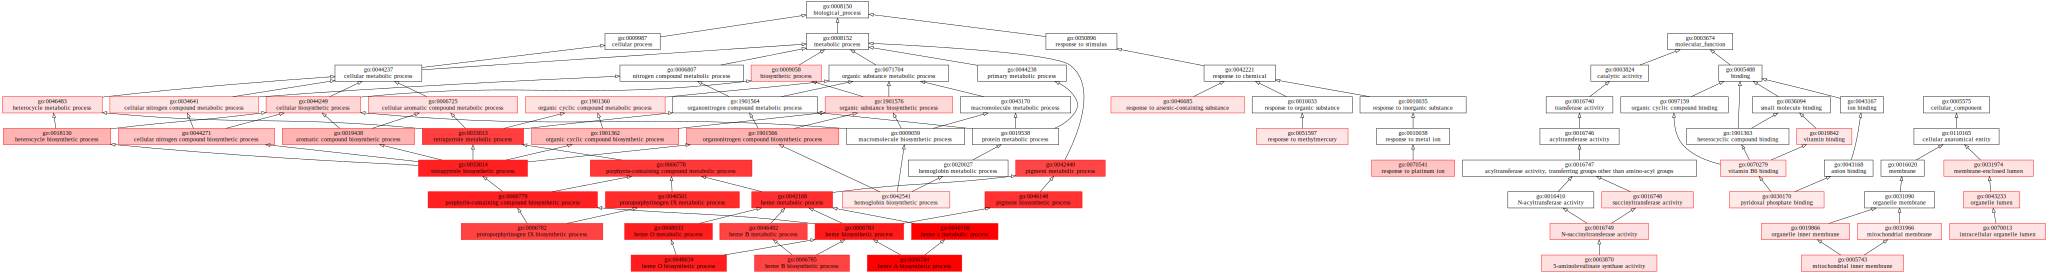

In [48]:
filteredGraph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
for currentGO in annotationsWithColorsSignificant.index:
    addAnnotationAncestors(currentGO, annotationsWithColorsSignificant, "rgb", filteredGraph)
filteredGraph

In [49]:
filteredGraph.format = "pdf"
filteredGraph.render("results/{}-reduced-threshold-0.005-pValue".format(setOfInterest))
filteredGraph.format = "png"
filteredGraph.render("results/{}-reduced-threshold-0.005-pValue".format(setOfInterest))

'results/set2-reduced-threshold-0.005-pValue.png'

![Set1 over-represented GO terms (Bonferroni; threshold: <= 0.005). Color=pValue](results/set1-reduced-threshold-0.005.png)

**Legend:** Set1 over-represented GO terms (Bonferroni; threshold: <= 0.005) with red border, and their ancestors with black border. For the over-represented terms, the background color is proportional to p-value.

> **Interpretation:**
> - many closely-related terms (with high semantic similarity, so likely to be clustered together by revigo)
> - many ancestors of the relevant terms do not really bring relevant information but are still significant
> - a few terms that do not appear to be semantically related (is there a good biological motivation, though?)
>     - response to platinum ion
>     - response to arsenic-containing substance
>     - response to methylmercury

In [50]:
filteredGraph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
for currentGO in annotationsWithColorsSignificant.index:
    addAnnotationAncestors(currentGO, annotationsWithColorsSignificant, "rgbICcoverage", filteredGraph)
filteredGraph

filteredGraph.format = "pdf"
filteredGraph.render("results/{}-reduced-threshold-0.005-ICcoverage".format(setOfInterest))
filteredGraph.format = "png"
filteredGraph.render("results/{}-reduced-threshold-0.005-ICcoverage".format(setOfInterest))

'results/set2-reduced-threshold-0.005-ICcoverage.png'

![Set1 over-represented GO terms (Bonferroni; threshold: <= 0.005). Color=ICcoverage](results/set1-reduced-threshold-0.005-ICcoverage.png)

**Legend:** Set1 over-represented GO terms (Bonferroni; threshold: <= 0.005) with red border, and their ancestors with black border. For the over-represented terms, the background color is proportional to IC coverage.

# Strategy 1: significant GO terms that do not have a significant ancestor

In [51]:
query = """
SELECT DISTINCT ?annotation ?annotationLabel ?adjPvalue
WHERE {
  ?annotation od:pAdj ?adjPvalue .
  ?annotation rdfs:label ?annotationLabel .
  FILTER NOT EXISTS {
    ?annotation rdfs:subClassOf+ ?annotationAncestor .
    ?annotationAncestor od:pAdj ?adjPvalueAncestor .
  }
}
ORDER BY DESC(?adjPvalue)
"""

sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.query().convert()
results = sparql.queryAndConvert()
displaySparqlResults(results)

Nb results: 14



In [52]:
query = """
SELECT DISTINCT ?annotation 
WHERE {
  ?annotation od:pAdj ?adjPvalue .
  ?annotation rdfs:label ?annotationLabel .
  FILTER NOT EXISTS {
    ?annotation rdfs:subClassOf+ ?annotationAncestor .
    ?annotationAncestor od:pAdj ?adjPvalueAncestor .
  }
}
ORDER BY DESC(?adjPvalue)
"""

dfStrategy1 = sparqldataframe.query(goaEndpointURL, prefixes+query)
dfStrategy1

annotation
0   http://purl.obolibrary.org/obo/GO_0031966
1   http://purl.obolibrary.org/obo/GO_0019842
2   http://purl.obolibrary.org/obo/GO_0051597
3   http://purl.obolibrary.org/obo/GO_0034641
4   http://purl.obolibrary.org/obo/GO_0046685
5   http://purl.obolibrary.org/obo/GO_0016748
6   http://purl.obolibrary.org/obo/GO_0019866
7   http://purl.obolibrary.org/obo/GO_0031974
8   http://purl.obolibrary.org/obo/GO_1901360
9   http://purl.obolibrary.org/obo/GO_0006725
10  http://purl.obolibrary.org/obo/GO_0046483
11  http://purl.obolibrary.org/obo/GO_0009058
12  http://purl.obolibrary.org/obo/GO_0070541
13  http://purl.obolibrary.org/obo/GO_0042440

In [53]:
annotationsWithColors.head()

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   

                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0046160     heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784  heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783    heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048034  heme O biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048033     heme O metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  1.452480e-30   
http://purl.obolibrary.org/obo/GO_0048034  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0048033  7.687844   69.190600  4.194550e-30   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006784  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006783  6.173041e-28  #ff1919       #0808ff  
http://purl.obolibrary.org/obo/GO_0048034  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0048033  1.782684e-27  #ff1d1d       #1616ff

In [54]:
dfStrategy1.head()

annotation
0  http://purl.obolibrary.org/obo/GO_0031966
1  http://purl.obolibrary.org/obo/GO_0019842
2  http://purl.obolibrary.org/obo/GO_0051597
3  http://purl.obolibrary.org/obo/GO_0034641
4  http://purl.obolibrary.org/obo/GO_0046685

In [55]:
dfStrategy1.set_index('annotation', inplace=True)
dfStrategy1.head()

Empty DataFrame
Columns: []
Index: [http://purl.obolibrary.org/obo/GO_0031966, http://purl.obolibrary.org/obo/GO_0019842, http://purl.obolibrary.org/obo/GO_0051597, http://purl.obolibrary.org/obo/GO_0034641, http://purl.obolibrary.org/obo/GO_0046685]

In [56]:
annotationsWithColorsSignificantStrategy1 = pd.merge(annotationsWithColors, dfStrategy1, right_index = True, left_index = True)
annotationsWithColorsSignificantStrategy1.head()

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   

                                                                                goLabel  \
http://purl.obolibrary.org/obo/GO_0042440                     pigment metabolic process   
http://purl.obolibrary.org/obo/GO_0070541                      response to platinum ion   
http://purl.obolibrary.org/obo/GO_0009058                          biosynthetic process   
http://purl.obolibrary.org/obo/GO_0046483                 heterocycle metabolic process   
http://purl.obolibrary.org/obo/GO_0006725  cellular aromatic compound metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0042440  5.741934   63.161277  1.992384e-25   
http://purl.obolibrary.org/obo/GO_0070541  8.786457   26.359370  3.606918e-10   
http://purl.obolibrary.org/obo/GO_0009058  2.104348   23.147829  7.390111e-08   
http://purl.obolibrary.org/obo/GO_0046483  1.943773   21.381507  3.970680e-07   
http://purl.obolibrary.org/obo/GO_0006725  1.928592   21.214514  4.650646e-07   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0042440  8.467632e-23  #ff4545       #2a2aff  
http://purl.obolibrary.org/obo/GO_0070541  1.532940e-07  #ffc5c5       #a6a6ff  
http://purl.obolibrary.org/obo/GO_0009058  3.140797e-05  #ffd9d9       #b1b1ff  
http://purl.obolibrary.org/obo/GO_0046483  1.687539e-04  #ffdfdf       #b7b7ff  
http://purl.obolibrary.org/obo/GO_0006725  1.976525e-04  #ffdfdf       #b7b7ff

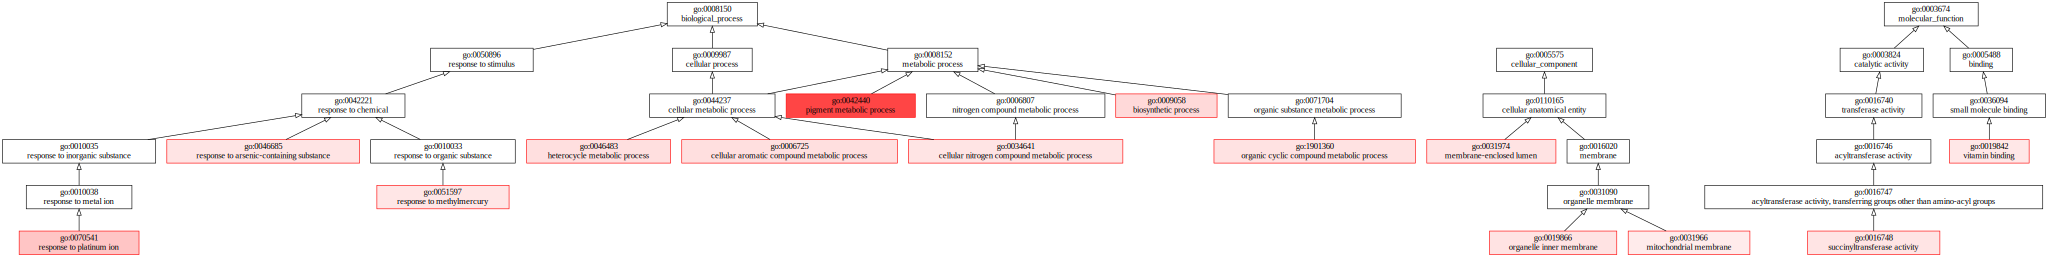

In [62]:
filteredGraph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)

for currentGO in annotationsWithColorsSignificantStrategy1.index:
    addAnnotationAncestors(currentGO, annotationsWithColorsSignificantStrategy1, "rgb", filteredGraph)
filteredGraph

# Strategy 2

> - `dfProteinGOSet1` contains the mappings between 
>     - the 11 genes from Set1
>     - the 51 significantly enriched GO terms
> - `annotationsWithColorsSignificant` contains 

In [66]:
#dfProteinGOSet1.head()
dfOfInterest.head()

uniprotID  \
0  http://purl.uniprot.org/uniprot/P13196   
1  http://purl.uniprot.org/uniprot/P13196   
2  http://purl.uniprot.org/uniprot/P13196   
3  http://purl.uniprot.org/uniprot/P13196   
4  http://purl.uniprot.org/uniprot/P13196   

                                        goID  
0  http://purl.obolibrary.org/obo/GO_0048821  
1  http://purl.obolibrary.org/obo/GO_0061515  
2  http://purl.obolibrary.org/obo/GO_0030097  
3  http://purl.obolibrary.org/obo/GO_0048468  
4  http://purl.obolibrary.org/obo/GO_0048869

In [68]:
#dfProteinGOSet1.shape
dfOfInterest.shape

(1125, 2)

In [69]:
#len(dfProteinGOSet1['uniprotID'].unique())
len(dfOfInterest['uniprotID'].unique())

12

In [70]:
#len(dfProteinGOSet1['goID'].unique())
len(dfOfInterest['goID'].unique())

425

> `dfProteinGOSet1` contains all the annotations of the proteins from set1

In [71]:
annotationsWithColorsSignificant.head()

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   

                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0046160     heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784  heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783    heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048034  heme O biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048033     heme O metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  1.452480e-30   
http://purl.obolibrary.org/obo/GO_0048034  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0048033  7.687844   69.190600  4.194550e-30   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006784  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006783  6.173041e-28  #ff1919       #0808ff  
http://purl.obolibrary.org/obo/GO_0048034  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0048033  1.782684e-27  #ff1d1d       #1616ff

In [72]:
annotationsWithColorsSignificant.shape

(44, 9)

In [73]:
len(annotationsWithColorsSignificant.index.unique())

44

In [74]:
#dfStrategy2 = pd.merge(dfProteinGOSet1, annotationsWithColorsSignificant, left_on = 'goID', right_index = True)
dfStrategy2 = pd.merge(dfOfInterest, annotationsWithColorsSignificant, left_on = 'goID', right_index = True)

# annotationsWithColorsSignificant
# , right_index = True, left_index = True
dfStrategy2.head()

uniprotID  \
9    http://purl.uniprot.org/uniprot/P13196   
194  http://purl.uniprot.org/uniprot/P50336   
344  http://purl.uniprot.org/uniprot/P36551   
441  http://purl.uniprot.org/uniprot/P13716   
573  http://purl.uniprot.org/uniprot/P06132   

                                          goID  nbUniprotSet2  \
9    http://purl.obolibrary.org/obo/GO_0006782              8   
194  http://purl.obolibrary.org/obo/GO_0006782              8   
344  http://purl.obolibrary.org/obo/GO_0006782              8   
441  http://purl.obolibrary.org/obo/GO_0006782              8   
573  http://purl.obolibrary.org/obo/GO_0006782              8   

     nbUniprotReference                                     goLabel        IC  \
9                     9  protoporphyrinogen IX biosynthetic process  7.687844   
194                   9  protoporphyrinogen IX biosynthetic process  7.687844   
344                   9  protoporphyrinogen IX biosynthetic process  7.687844   
441                   9  protoporphyrinogen IX biosynthetic process  7.687844   
573                   9  protoporphyrinogen IX biosynthetic process  7.687844   

     ICcoverage        pValue    bonferroni      rgb rgbICcoverage  
9     61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
194   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
344   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
441   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
573   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff

In [75]:
dfStrategy2.shape

(359, 11)

In [76]:
len(dfStrategy2['uniprotID'].unique())

12

In [77]:
len(dfStrategy2['goID'].unique())

44

> **Initial situation:**
> - set1
>     - 419 relations between:
>         - 11 proteins from Set1
>         - 51 significantly over-represented GO terms (threshold = 0.005)
> - set2
>     - 359 relations between:
>         - 12 proteins from Set1
>         - 44 significantly over-represented GO terms (threshold = 0.005)

In [78]:
dfStrategy2.sort_values(by="IC", ascending = False)

uniprotID  \
85   http://purl.uniprot.org/uniprot/P13196   
719  http://purl.uniprot.org/uniprot/P22557   
86   http://purl.uniprot.org/uniprot/P13196   
720  http://purl.uniprot.org/uniprot/P22557   
773  http://purl.uniprot.org/uniprot/P10746   
..                                      ...   
750  http://purl.uniprot.org/uniprot/P08397   
801  http://purl.uniprot.org/uniprot/P10746   
890  http://purl.uniprot.org/uniprot/Q12887   
989  http://purl.uniprot.org/uniprot/P22830   
666  http://purl.uniprot.org/uniprot/P22557   

                                          goID  nbUniprotSet2  \
85   http://purl.obolibrary.org/obo/GO_0003870              2   
719  http://purl.obolibrary.org/obo/GO_0003870              2   
86   http://purl.obolibrary.org/obo/GO_0016749              2   
720  http://purl.obolibrary.org/obo/GO_0016749              2   
773  http://purl.obolibrary.org/obo/GO_0070541              3   
..                                         ...            ...   
750  http://purl.obolibrary.org/obo/GO_0034641             11   
801  http://purl.obolibrary.org/obo/GO_0034641             11   
890  http://purl.obolibrary.org/obo/GO_0034641             11   
989  http://purl.obolibrary.org/obo/GO_0034641             11   
666  http://purl.obolibrary.org/obo/GO_0034641             11   

     nbUniprotReference                                       goLabel  \
85                    2           5-aminolevulinate synthase activity   
719                   2           5-aminolevulinate synthase activity   
86                    2                N-succinyltransferase activity   
720                   2                N-succinyltransferase activity   
773                   3                      response to platinum ion   
..                  ...                                           ...   
750                3266  cellular nitrogen compound metabolic process   
801                3266  cellular nitrogen compound metabolic process   
890                3266  cellular nitrogen compound metabolic process   
989                3266  cellular nitrogen compound metabolic process   
666                3266  cellular nitrogen compound metabolic process   

           IC  ICcoverage        pValue    bonferroni      rgb rgbICcoverage  
85   9.191922   18.383844  5.447279e-07  2.315093e-04  #ffe0e0       #c1c1ff  
719  9.191922   18.383844  5.447279e-07  2.315093e-04  #ffe0e0       #c1c1ff  
86   9.191922   18.383844  5.447279e-07  2.315093e-04  #ffe0e0       #c1c1ff  
720  9.191922   18.383844  5.447279e-07  2.315093e-04  #ffe0e0       #c1c1ff  
773  8.786457   26.359370  3.606918e-10  1.532940e-07  #ffc5c5       #a6a6ff  
..        ...         ...           ...           ...      ...           ...  
750  1.793748   19.731225  1.879007e-06  7.985780e-04  #ffe4e4       #bcbcff  
801  1.793748   19.731225  1.879007e-06  7.985780e-04  #ffe4e4       #bcbcff  
890  1.793748   19.731225  1.879007e-06  7.985780e-04  #ffe4e4       #bcbcff  
989  1.793748   19.731225  1.879007e-06  7.985780e-04  #ffe4e4       #bcbcff  
666  1.793748   19.731225  1.879007e-06  7.985780e-04  #ffe4e4       #bcbcff  

[359 rows x 11 columns]

> **Interpretation:**
> The annotations with the highest IC are rather precise and only annotate 2 of the 11 proteins of interest

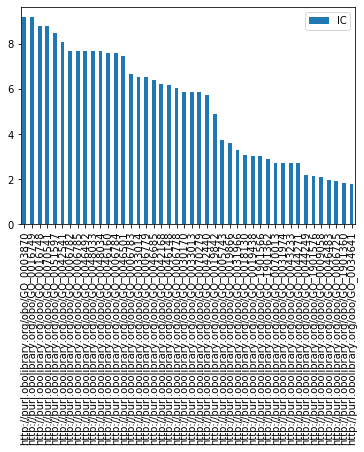

In [79]:
fig = annotationsWithColorsSignificant.sort_values(by="IC", ascending = False).plot.bar(y = 'IC')
fig.get_figure().savefig("results/{}-reduced-threshold-0.005-annotationIC.png".format(setOfInterest))

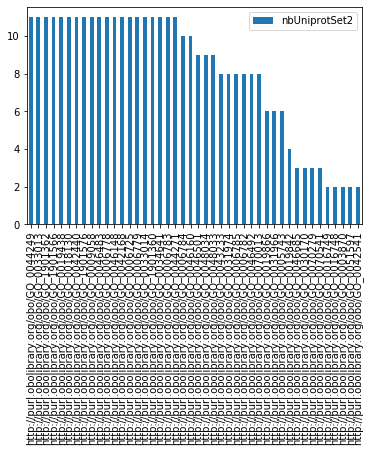

In [83]:
fig = annotationsWithColorsSignificant.sort_values(by="nbUniprot"+setOfInterest.capitalize(), ascending = False).plot.bar(y = 'nbUniprot'+setOfInterest.capitalize())
fig.get_figure().savefig("results/{}-reduced-threshold-0.005-annotationCoverage.png".format(setOfInterest))

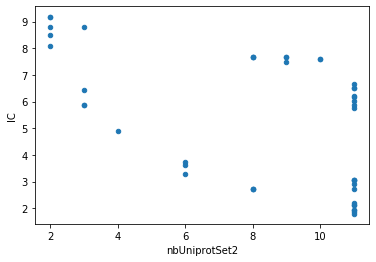

In [84]:
fig = annotationsWithColorsSignificant.plot.scatter(x = 'nbUniprot'+setOfInterest.capitalize(), y = 'IC')
fig.get_figure().savefig("results/{}-reduced-threshold-0.005-annotationCoverageIC.png".format(setOfInterest))

> **Interpretation:**
> There are some annotations with rather high IC (slightly below 7) that cover all the 11 proteins of interest, and another annotation with a higher IC (around 7.5) that covers 10 of the 11 proteins of interest. 
> Identify:
> - the annotation with the highest IC annotating 11 proteins
> - the annotation with the highest IC annotating 10 proteins
>
> Note that the scatterplot does not take into account the subsumption relations between the annotations

In [85]:
annotationsWithColorsSignificant[annotationsWithColorsSignificant['nbUniprot'+setOfInterest.capitalize()] == 11].sort_values(by = 'IC', ascending = False)

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0033014                  tetrapyrrole biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006779  porphyrin-containing compound biosynthetic pro...   
http://purl.obolibrary.org/obo/GO_0042168                             heme metabolic process   
http://purl.obolibrary.org/obo/GO_0046148                       pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006778    porphyrin-containing compound metabolic process   
http://purl.obolibrary.org/obo/GO_0033013                     tetrapyrrole metabolic process   
http://purl.obolibrary.org/obo/GO_0042440                          pigment metabolic process   
http://purl.obolibrary.org/obo/GO_0018130                   heterocycle biosynthetic process   
http://purl.obolibrary.org/obo/GO_0019438             aromatic compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901566       organonitrogen compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901362       organic cyclic compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_0044271    cellular nitrogen compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_0044249                      cellular biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901576             organic substance biosynthetic process   
http://purl.obolibrary.org/obo/GO_0009058                               biosynthetic process   
http://purl.obolibrary.org/obo/GO_0046483                      heterocycle metabolic process   
http://purl.obolibrary.org/obo/GO_0006725       cellular aromatic compound metabolic process   
http://purl.obolibrary.org/obo/GO_1901360          organic cyclic compound metabolic process   
http://purl.obolibrary.org/obo/GO_0034641       cellular nitrogen compound metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0006783  6.666193   73.328125  1.452480e-30   
http://purl.obolibrary.org/obo/GO_0033014  6.517773   71.695505  1.126538e-29   
http://purl.obolibrary.org/obo/GO_0006779  6.517773   71.695505  1.126538e-29   
http://purl.obolibrar

In [86]:
annotationsWithColorsSignificant[annotationsWithColorsSignificant['nbUniprot'+setOfInterest.capitalize()] == 10].sort_values(by = 'IC', ascending = False)

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   

                                                               goLabel  \
http://purl.obolibrary.org/obo/GO_0046160     heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784  heme A biosynthetic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0046160  7.582484   75.824839  1.282345e-33   
http://purl.obolibrary.org/obo/GO_0006784  7.582484   75.824839  1.282345e-33   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0046160  5.449965e-31  #ff0000       #0000ff  
http://purl.obolibrary.org/obo/GO_0006784  5.449965e-31  #ff0000       #0000ff

In [87]:
annotationsWithColorsSignificant[annotationsWithColorsSignificant['nbUniprot'+setOfInterest.capitalize()] == 9].sort_values(by = 'IC', ascending = False)

nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   

                                                                           goLabel  \
http://purl.obolibrary.org/obo/GO_0048034              heme O biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048033                 heme O metabolic process   
http://purl.obolibrary.org/obo/GO_0046501  protoporphyrinogen IX metabolic process   

                                                 IC  ICcoverage        pValue  \
http://purl.obolibrary.org/obo/GO_0048034  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0048033  7.687844   69.190600  4.194550e-30   
http://purl.obolibrary.org/obo/GO_0046501  7.487174   67.384563  2.305733e-28   

                                             bonferroni      rgb rgbICcoverage  
http://purl.obolibrary.org/obo/GO_0048034  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0048033  1.782684e-27  #ff1d1d       #1616ff  
http://purl.obolibrary.org/obo/GO_0046501  9.799365e-26  #ff2c2c       #1c1cff

![Set1: annotated scatterplot of coverage (x-axis) VS IC (y-axis)](results/set1-reduced-threshold-0.005-annotationCoverageIC-labeled.png)

**Legend:** Set1: annotated scatterplot of coverage (x-axis) VS IC (y-axis)

In [88]:
#dfCandidateAnnotations = pd.DataFrame(index=annotationsWithColorsSignificant.index)
dfCandidateAnnotations = pd.DataFrame(index=dfStrategy2['goID'].unique())
#dfCandidateAnnotations.head()
len(dfCandidateAnnotations)
#dfCandidateAnnotations.loc['http://purl.obolibrary.org/obo/GO_0006784']

44

In [89]:
dfStrategy2.head()

uniprotID  \
9    http://purl.uniprot.org/uniprot/P13196   
194  http://purl.uniprot.org/uniprot/P50336   
344  http://purl.uniprot.org/uniprot/P36551   
441  http://purl.uniprot.org/uniprot/P13716   
573  http://purl.uniprot.org/uniprot/P06132   

                                          goID  nbUniprotSet2  \
9    http://purl.obolibrary.org/obo/GO_0006782              8   
194  http://purl.obolibrary.org/obo/GO_0006782              8   
344  http://purl.obolibrary.org/obo/GO_0006782              8   
441  http://purl.obolibrary.org/obo/GO_0006782              8   
573  http://purl.obolibrary.org/obo/GO_0006782              8   

     nbUniprotReference                                     goLabel        IC  \
9                     9  protoporphyrinogen IX biosynthetic process  7.687844   
194                   9  protoporphyrinogen IX biosynthetic process  7.687844   
344                   9  protoporphyrinogen IX biosynthetic process  7.687844   
441                   9  protoporphyrinogen IX biosynthetic process  7.687844   
573                   9  protoporphyrinogen IX biosynthetic process  7.687844   

     ICcoverage        pValue    bonferroni      rgb rgbICcoverage  
9     61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
194   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
344   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
441   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
573   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff

In [90]:
dfCandidateAnnotations.join(dfOfInterest.set_index('goID'), how='inner')['uniprotID'].unique()

array(['http://purl.uniprot.org/uniprot/P13196',
       'http://purl.uniprot.org/uniprot/P22557',
       'http://purl.uniprot.org/uniprot/Q7KZN9',
       'http://purl.uniprot.org/uniprot/P50336',
       'http://purl.uniprot.org/uniprot/Q12887',
       'http://purl.uniprot.org/uniprot/P22830',
       'http://purl.uniprot.org/uniprot/P36551',
       'http://purl.uniprot.org/uniprot/P13716',
       'http://purl.uniprot.org/uniprot/P06132',
       'http://purl.uniprot.org/uniprot/P08397',
       'http://purl.uniprot.org/uniprot/P10746',
       'http://purl.uniprot.org/uniprot/P02768'], dtype=object)

In [91]:
dfStrategy2[dfStrategy2['goID']== "http://purl.obolibrary.org/obo/GO_0006782"]

uniprotID  \
9    http://purl.uniprot.org/uniprot/P13196   
194  http://purl.uniprot.org/uniprot/P50336   
344  http://purl.uniprot.org/uniprot/P36551   
441  http://purl.uniprot.org/uniprot/P13716   
573  http://purl.uniprot.org/uniprot/P06132   
645  http://purl.uniprot.org/uniprot/P22557   
727  http://purl.uniprot.org/uniprot/P08397   
779  http://purl.uniprot.org/uniprot/P10746   

                                          goID  nbUniprotSet2  \
9    http://purl.obolibrary.org/obo/GO_0006782              8   
194  http://purl.obolibrary.org/obo/GO_0006782              8   
344  http://purl.obolibrary.org/obo/GO_0006782              8   
441  http://purl.obolibrary.org/obo/GO_0006782              8   
573  http://purl.obolibrary.org/obo/GO_0006782              8   
645  http://purl.obolibrary.org/obo/GO_0006782              8   
727  http://purl.obolibrary.org/obo/GO_0006782              8   
779  http://purl.obolibrary.org/obo/GO_0006782              8   

     nbUniprotReference                                     goLabel        IC  \
9                     9  protoporphyrinogen IX biosynthetic process  7.687844   
194                   9  protoporphyrinogen IX biosynthetic process  7.687844   
344                   9  protoporphyrinogen IX biosynthetic process  7.687844   
441                   9  protoporphyrinogen IX biosynthetic process  7.687844   
573                   9  protoporphyrinogen IX biosynthetic process  7.687844   
645                   9  protoporphyrinogen IX biosynthetic process  7.687844   
727                   9  protoporphyrinogen IX biosynthetic process  7.687844   
779                   9  protoporphyrinogen IX biosynthetic process  7.687844   

     ICcoverage        pValue    bonferroni      rgb rgbICcoverage  
9     61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
194   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
344   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
441   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
573   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
645   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
727   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff  
779   61.502755  1.058147e-25  4.497125e-23  #ff4242       #3030ff

In [92]:
def getDescendants(goID):
    query = """
SELECT DISTINCT ?desc
WHERE {
  ?desc rdfs:subClassOf+ """ + goID + """ .
  ?desc rdf:type owl:Class .
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    desc = set()
    for result in results["results"]["bindings"]:
        desc.add(result["desc"]["value"])
    return desc

In [93]:
def getAnnotationSummaryStrategy2(dfAnnotations):
    candidateAnnotations = {}
    for goID in dfAnnotations['goID'].unique():
        candidateAnnotations[goID] = {}
        candidateAnnotations[goID]['label'] = list(dfAnnotations[dfAnnotations['goID']==goID]['goLabel'])[0]
        candidateAnnotations[goID]['IC'] = list(dfAnnotations[dfAnnotations['goID']==goID]['IC'])[0]
        candidateAnnotations[goID]['elementsAnnotatedBySummary'] = set()
        candidateAnnotations[goID]['elementsNotAnnotatedBySummary'] = set(dfAnnotations[dfAnnotations['goID']==goID]['uniprotID'].unique())
    print(str(len(candidateAnnotations.keys())))
    summaryAnnotations = {}
    elementsAnnotatedBySummary = set()
    elementsAnnotatedByCandidate = set(dfAnnotations['uniprotID'].unique())
    
    print()
    print("Nb annotations in summary: {}".format(len(summaryAnnotations.keys())))
    print("Nb candidate annotations: {}".format(len(candidateAnnotations.keys())))
    print("Nb elements annotated by summary: {}".format(len(elementsAnnotatedBySummary)))
    print("Nb elements not annotated by summary: {}".format(len(elementsAnnotatedByCandidate)))
    while(len(elementsAnnotatedByCandidate - elementsAnnotatedBySummary) > 0):
        print("//////////")
        print("Nb candidate annotations: {}".format(len(candidateAnnotations)))
        maxICcoverageCandidate = 0
        maxICcoverageCandidateAnnotations = set()
        for goID, goVal in candidateAnnotations.items():
            coverageIC = goVal['IC'] * len(goVal['elementsNotAnnotatedBySummary'])
            #coverageIC = goVal['IC'] * ((len(goVal['elementsNotAnnotatedBySummary']) / max(1, len(elementsAnnotatedByCandidate))) + (len(goVal['elementsAnnotatedBySummary']) / max(1, len(elementsAnnotatedBySummary))))
            #coverageIC = goVal['IC'] * (len(goVal['elementsNotAnnotatedBySummary']) / max(1, len(elementsAnnotatedByCandidate))) * (len(goVal['elementsAnnotatedBySummary']) + len(goVal['elementsNotAnnotatedBySummary']) )
            #coverageIC = goVal['IC'] * len(goVal['elementsNotAnnotatedBySummary']) * max(1, len(goVal['elementsAnnotatedBySummary']))
            coverageIC = goVal['IC'] * (len(goVal['elementsNotAnnotatedBySummary']) + len(goVal['elementsAnnotatedBySummary']))
            
            #if goID == "http://purl.obolibrary.org/obo/GO_0046501":
            #    print("// // // // // annot: elts not annotated by summary")
            #    for x in goVal['elementsNotAnnotatedBySummary']:
            #        print("  " + str(x))
            #    print("// // // // // elementsAnnotatedByCandidate")
            #    for x in elementsAnnotatedByCandidate:
            #        print("  " + str(x))
            #    print("// // // // // annot: elts annotated by summary")
            #    for x in goVal['elementsAnnotatedBySummary']:
            #        print("  " + str(x))
            #    print("// // // // // elementsAnnotatedBySummary")
            #    for x in elementsAnnotatedBySummary:
            #        print("  " + str(x))
            if coverageIC > maxICcoverageCandidate:
                maxICcoverageCandidate = coverageIC
                maxICcoverageCandidateAnnotations = set()
                maxICcoverageCandidateAnnotations.add(goID)
            elif coverageIC == maxICcoverageCandidate:
                maxICcoverageCandidateAnnotations.add(goID)
            #print("{} {}".format(goID, coverageIC))
        print()
        
        # CHECK REDUNDANCY AMONG BEST CANDIDATE(S)
        # AND REMOVE THE SUPERCLASS IF IT HAS THE SAME COVERAGE
        # AS ITS SUBCLASS
        redundantCandidates = set()
        for goID1 in maxICcoverageCandidateAnnotations:
            goID1desc = getDescendants("<{}>".format(goID1))
            for goID2 in maxICcoverageCandidateAnnotations:
                if goID1 == goID2:
                    continue
                if (goID2 in goID1desc) and (candidateAnnotations[goID1]['elementsAnnotatedBySummary'] == candidateAnnotations[goID2]['elementsAnnotatedBySummary']) and (candidateAnnotations[goID1]['elementsNotAnnotatedBySummary'] == candidateAnnotations[goID2]['elementsNotAnnotatedBySummary']):
                    redundantCandidates.add(goID1)
        for goID in redundantCandidates:
            print("***** REDUNDANT CANDIDATE removing {}".format(goID))
            del candidateAnnotations[goID]
            maxICcoverageCandidateAnnotations.discard(goID)
        
        print("Best candidate(s): {} {}".format(maxICcoverageCandidate, maxICcoverageCandidateAnnotations))
        # TODO
        #if len(maxICcoverageCandidateAnnotations) > 1:
            # multiple candidates
            # if subsumption, remove ancestor(s) if same length of elementsAnnotatedByCandidate than the descendant
            # if still >=2, choose the one(s) annotating the most elements already annotated by the summary
        # DONE
        # remove from candidateAnnotations the descendants of the annotations in maxICcoverageCandidateAnnotations
        # 
        descendantsFromNewCandidates = set()
        for goID1 in maxICcoverageCandidateAnnotations:
            goID1desc = getDescendants("<{}>".format(goID1))
            for goID2 in candidateAnnotations:
                if (goID2 in goID1desc) and (goID2 not in maxICcoverageCandidateAnnotations):
                    descendantsFromNewCandidates.add(goID2)
        for goID2 in descendantsFromNewCandidates:
            del candidateAnnotations[goID2]
        
        
        for goID in maxICcoverageCandidateAnnotations:
            summaryAnnotations[goID] = candidateAnnotations[goID]
            del candidateAnnotations[goID]
            for eltID in summaryAnnotations[goID]['elementsNotAnnotatedBySummary']:
                elementsAnnotatedBySummary.add(eltID)
                elementsAnnotatedByCandidate.discard(eltID)
            summaryAnnotations[goID]['elementsAnnotatedBySummary'] = summaryAnnotations[goID]['elementsAnnotatedBySummary'] | summaryAnnotations[goID]['elementsNotAnnotatedBySummary']
            summaryAnnotations[goID]['elementsNotAnnotatedBySummary'] = set()
            
            
        # REMOVE CANDIDATE ANNOTATIONS
        # THAT DO NOT ANNOTATE ANY REMAINING CANDIDATE ELEMENTS
        uselessCandidates = set()
        for goID, goVal in candidateAnnotations.items():
            if len(goVal['elementsNotAnnotatedBySummary']) == 0:
                uselessCandidates.add(goID)
        for goID in uselessCandidates:
            print(":-) remove useless candidate: {} {}".format(goID, candidateAnnotations[goID]['label']))
            del candidateAnnotations[goID]
        
        print("Elements annotated by Summary:")
        for prot in elementsAnnotatedBySummary:
            print("  - {}".format(prot))
        print("Elements remaining to be annotated:")
        for prot in elementsAnnotatedByCandidate - elementsAnnotatedBySummary:
            print("  - {}".format(prot))
        for goID, goVal in candidateAnnotations.items():
            eltsNewlyAnnotated = set()
            for prot in goVal['elementsNotAnnotatedBySummary']:
                if prot in elementsAnnotatedBySummary:
                    eltsNewlyAnnotated.add(prot)
            for prot in eltsNewlyAnnotated:
                goVal['elementsAnnotatedBySummary'].add(prot)
                goVal['elementsNotAnnotatedBySummary'].discard(prot)
        for goID, goVal in summaryAnnotations.items():
            eltsNewlyAnnotated = set()
            for prot in goVal['elementsNotAnnotatedBySummary']:
                if prot in elementsAnnotatedBySummary:
                    eltsNewlyAnnotated.add(prot)
            for prot in eltsNewlyAnnotated:
                goVal['elementsAnnotatedBySummary'].add(prot)
                goVal['elementsNotAnnotatedBySummary'].discard(prot)
    # DONE
    # summarize the summary :-)
    # i.e. detect annotations that are no longer necessary because subsumed by some 
    # other annotation in the summary
    redundantAnnotationInSummary = set()
    for annot1 in summaryAnnotations.keys():
        annot1Desc = getDescendants("<{}>".format(annot1))
        for annot2 in summaryAnnotations.keys():
            if annot1 == annot2:
                continue
            if annot2 in annot1Desc:
                redundantAnnotationInSummary.add(annot2)
            else:
                annot2Desc = getDescendants("<{}>".format(annot2))
                if annot1 in annot2Desc:
                    redundantAnnotationInSummary.add(annot1)
    for redundantAnnot in redundantAnnotationInSummary:
        print("Remove redundant annotation from summary: {}".format(redundantAnnot))
        del summaryAnnotations[redundantAnnot]
        
        # 
        # REMOVE FROM HERE
        #print("!!!!! DEBUG START !!!!!")
        #for goID, goVal in candidateAnnotations.items():
        #    print("{} {} ({})".format(goID, goVal['label'], goVal['IC']))
        #    print("  Elts NOT annotated by summary:")
        #    if len(goVal['elementsNotAnnotatedBySummary']) == 0:
        #        print("    NONE")
        #    for prot in goVal['elementsNotAnnotatedBySummary']:
        #        print("    {}".format(prot))
        #    print("  Elts ANNOTATED by summary:")
        #    if len(goVal['elementsAnnotatedBySummary']) == 0:
        #        print("    NONE")
        #    for prot in goVal['elementsAnnotatedBySummary']:
        #        print("    {}".format(prot))
        #print("!!!!! DEBUG END !!!!!")
        ###elementsAnnotatedByCandidate = set()
    for (annotID, annotVal) in summaryAnnotations.items():
        annotVal['cumulativeInformationContent'] = annotVal['IC'] * len(annotVal['elementsAnnotatedBySummary'])
    print()
    print("Nb annotations in summary: {}".format(len(summaryAnnotations.keys())))
    print("Nb candidate annotations: {}".format(len(candidateAnnotations.keys())))
    print("Nb elements annotated by summary: {}".format(len(elementsAnnotatedBySummary)))
    print("Nb elements not annotated by summary: {}".format(len(elementsAnnotatedByCandidate)))
    return summaryAnnotations

getAnnotationSummaryStrategy2(dfStrategy2)

44

Nb annotations in summary: 0
Nb candidate annotations: 44
Nb elements annotated by summary: 0
Nb elements not annotated by summary: 12
//////////
Nb candidate annotations: 44

***** REDUNDANT CANDIDATE removing http://purl.obolibrary.org/obo/GO_0046160
Best candidate(s): 75.82483874018064 {'http://purl.obolibrary.org/obo/GO_0006784'}
Elements annotated by Summary:
  - http://purl.uniprot.org/uniprot/P36551
  - http://purl.uniprot.org/uniprot/P10746
  - http://purl.uniprot.org/uniprot/P50336
  - http://purl.uniprot.org/uniprot/Q12887
  - http://purl.uniprot.org/uniprot/Q7KZN9
  - http://purl.uniprot.org/uniprot/P08397
  - http://purl.uniprot.org/uniprot/P13716
  - http://purl.uniprot.org/uniprot/P13196
  - http://purl.uniprot.org/uniprot/P22830
  - http://purl.uniprot.org/uniprot/P06132
Elements remaining to be annotated:
  - http://purl.uniprot.org/uniprot/P22557
  - http://purl.uniprot.org/uniprot/P02768
//////////
Nb candidate annotations: 42

Best candidate(s): 73.328124563583 {

{'http://purl.obolibrary.org/obo/GO_0006779': {'label': 'porphyrin-containing compound biosynthetic process',
  'IC': 6.517773137025636,
  'elementsAnnotatedBySummary': {'http://purl.uniprot.org/uniprot/P06132',
   'http://purl.uniprot.org/uniprot/P08397',
   'http://purl.uniprot.org/uniprot/P10746',
   'http://purl.uniprot.org/uniprot/P13196',
   'http://purl.uniprot.org/uniprot/P13716',
   'http://purl.uniprot.org/uniprot/P22557',
   'http://purl.uniprot.org/uniprot/P22830',
   'http://purl.uniprot.org/uniprot/P36551',
   'http://purl.uniprot.org/uniprot/P50336',
   'http://purl.uniprot.org/uniprot/Q12887',
   'http://purl.uniprot.org/uniprot/Q7KZN9'},
  'elementsNotAnnotatedBySummary': set(),
  'cumulativeInformationContent': 71.695504507282},
 'http://purl.obolibrary.org/obo/GO_0070013': {'label': 'intracellular organelle lumen',
  'IC': 2.7359373684547035,
  'elementsAnnotatedBySummary': {'http://purl.uniprot.org/uniprot/P02768',
   'http://purl.uniprot.org/uniprot/P13196',
   'ht

In [94]:
annotationsWithColorsSignificant['nbUniprotSet1xIC'] = annotationsWithColorsSignificant['nbUniprot'+setOfInterest.capitalize()] * annotationsWithColorsSignificant['IC']
#annotationsWithColorsSignificant['nbUniprotSet1'] * annotationsWithColorsSignificant['IC']
#annotationsWithColorsSignificant['nbUniprotSet1xIC'] = annotationsWithColorsSignificant['nbUniprotSet1'].mul(annotationsWithColorsSignificant['IC'])
annotationsWithColorsSignificant

<ipython-input-94-37072518ff5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotationsWithColorsSignificant['nbUniprotSet1xIC'] = annotationsWithColorsSignificant['nbUniprot'+setOfInterest.capitalize()] * annotationsWithColorsSignificant['IC']


nbUniprotSet2  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0070013              8                1273   
http://purl.obolibrary.org/obo/GO_0031974              8                1273   
http://purl.obolibrary.org/obo/GO_0043233              8                1273   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0019842              4                 149   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0030170              3                  55   
http://purl.obolibrary.org/obo/GO_0070279              3                  56   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0046160                           heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784                        heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0048034                 

> **Interpretation:**
> The two annotations having the top `nbUniprotSet1xIC` are connected by a subClassOf relation
> - `go:0046160` heme a metabolic process
> - `0006784` heme A biosynthetic process

![](data/GO-heme_A_biosynthetic_process.png)

> **REMOVE FROM HERE**

In [51]:
dfStrategy2 = dfProteinGOSet1.copy()
dfStrategy2.head()

uniprotID  \
0  http://purl.uniprot.org/uniprot/P13196   
1  http://purl.uniprot.org/uniprot/P13196   
2  http://purl.uniprot.org/uniprot/P13196   
3  http://purl.uniprot.org/uniprot/P13196   
4  http://purl.uniprot.org/uniprot/P13196   

                                        goID  
0  http://purl.obolibrary.org/obo/GO_0048821  
1  http://purl.obolibrary.org/obo/GO_0061515  
2  http://purl.obolibrary.org/obo/GO_0030097  
3  http://purl.obolibrary.org/obo/GO_0048468  
4  http://purl.obolibrary.org/obo/GO_0048869

In [52]:
len(dfStrategy2['uniprotID'].unique())

11

In [53]:
len(dfStrategy2['goID'].unique())

389

# Temporary

In [34]:
annotationsWithColors = occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")
annotationsWithColors

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0044237             11                5656   
http://purl.obolibrary.org/obo/GO_0003824             11                5672   
http://purl.obolibrary.org/obo/GO_0031974              7                1273   
http://purl.obolibrary.org/obo/GO_0043233              7                1273   
http://purl.obolibrary.org/obo/GO_0070013              7                1273   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5929   
http://purl.obolibrary.org/obo/GO_0005739              7                1360   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6873   
http://purl.obolibrary.org/obo/GO_0020027  

In [35]:
minPval = annotationsWithColors["bonferroni"].min()
maxPval = annotationsWithColors["bonferroni"].max()
print("[{};{}]".format(minPval, maxPval))

[1.8272238326621285e-33;0.047871277746627326]


In [36]:
def getColor(pvalue, lowestPvalue):
    #return int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    val = int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    #return '0xff{:02x}{:02x}'.format(val, val)
    return '#ff{:02x}{:02x}'.format(val, val)

In [37]:
#annotationsWithColors["rgb"] = annotationsWithColors["bonferroni"].map(getColor)
annotationsWithColors["rgb"] = annotationsWithColors["bonferroni"].map(lambda x: getColor(x, minPval))
annotationsWithColors

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0044237             11                5656   
http://purl.obolibrary.org/obo/GO_0003824             11                5672   
http://purl.obolibrary.org/obo/GO_0031974              7                1273   
http://purl.obolibrary.org/obo/GO_0043233              7                1273   
http://purl.obolibrary.org/obo/GO_0070013              7                1273   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5929   
http://purl.obolibrary.org/obo/GO_0005739              7                1360   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6873   
http://purl.obolibrary.org/obo/GO_0020027  

In [38]:
annotationsWithColors.head()

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0046160                           heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784                        heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0033014                  tetrapyrrole biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006779  porphyrin-containing compound biosynthetic pro...   

                                                 pValue    bonferroni      rgb  
http://purl.obolibrary.org/obo/GO_0046160  4.697234e-36  1.827224e-33  #ff0000  
http://purl.obolibrary.org/obo/GO_0006784  4.697234e-36  1.827224e-33  #ff0000  
http://purl.obolibrary.org/obo/GO_0006783  1.066876e-33  4.150149e-31  #ff1212  
http://purl.obolibrary.org/obo/GO_0033014  8.280843e-33  3.221248e-30  #ff1919  
http://purl.obolibrary.org/obo/GO_0006779  8.280843e-33  3.221248e-30  #ff1919

In [39]:
annotationsWithColors["rgb"]["http://purl.obolibrary.org/obo/GO_0006783"]

'#ff1212'

In [40]:
print('http://purl.obolibrary.org/obo/GO_0006783' in annotationsWithColors.index)
print('http://purl.obolibrary.org/obo/GO_0009987' in annotationsWithColors.index)

True
False


# 5. display hierarchy

In [97]:
def addProteinAnnotationAncestors(uniprotID, dfAnnotationsColors, graph=None):
    if graph is None:
        graph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
    if not(uniprotID.startswith("uniprot:")):
        uniprotID = "<" + uniprotID + ">"
    query = """
SELECT DISTINCT ?annotation ?annotationLabel ?annotationParent ?annotationParentLabel
WHERE {
  VALUES ?protein { """ + uniprotID + """ }
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  ?annotation rdfs:label ?annotationLabel .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
  ?annotation rdfs:subClassOf ?annotationParent .
  ?annotationParent rdf:type owl:Class .
  ?annotationParent rdfs:label ?annotationParentLabel .
  FILTER (STRSTARTS(STR(?annotationParent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotationParent owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        goID = result["annotation"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        goParentID = result["annotationParent"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        nodeColor = "white"
        if result["annotation"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotation"]["value"]]
        graph.node("go"+goID, label="go:{}\n{}".format(goID, result["annotationLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor)
        
        nodeColor = "white"
        if result["annotationParent"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotationParent"]["value"]]
        graph.node("go"+goParentID, label="go:{}\n{}".format(goParentID, result["annotationParentLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor)
        graph.edge("go"+goID, "go"+goParentID, arrowhead="onormal")
    return graph

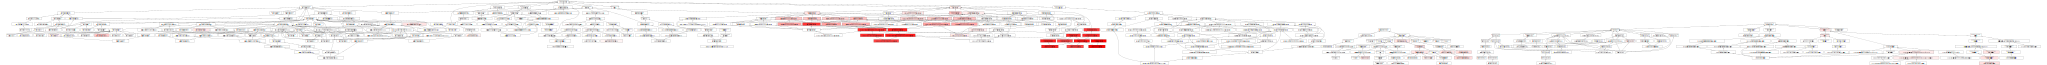

In [98]:
myGraph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
#addProteinAnnotationAncestors("uniprot:P06132", annotationsWithColors, myGraph)
for currentProtein in dfSet1.index:
    #print(currentProtein)
    addProteinAnnotationAncestors(currentProtein, annotationsWithColors, myGraph)
myGraph

![Partial view of the GO hierarchy with adjusted p-value](figures/enrichment_set1_cropped.png)

In [103]:
myGraph.format = "pdf"
myGraph.render("results/set1")

'results/set1.pdf'

In [41]:
def addAnnotationAncestors(goIdent, dfAnnotationsColors, graph=None):
    if graph is None:
        graph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
    if goIdent.startswith("http://purl.obolibrary.org/obo/GO_"):
        goIdent = goIdent.replace("http://purl.obolibrary.org/obo/GO_", "go:")
    if not(goIdent.startswith("go:")):
        goIdent = "<" + goIdent + ">"
    query = """
SELECT DISTINCT ?annotation ?annotationLabel ?annotationParent ?annotationParentLabel
WHERE {
  VALUES ?annotationDirect { """ + goIdent + """ }
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  ?annotation rdfs:label ?annotationLabel .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
  ?annotation rdfs:subClassOf ?annotationParent .
  ?annotationParent rdf:type owl:Class .
  ?annotationParent rdfs:label ?annotationParentLabel .
  FILTER (STRSTARTS(STR(?annotationParent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotationParent owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        goID = result["annotation"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        goParentID = result["annotationParent"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        nodeColor = "white"
        borderColor = "black"
        if result["annotation"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotation"]["value"]]
            borderColor = "red"
        graph.node("go"+goID, label="go:{}\n{}".format(goID, result["annotationLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        
        nodeColor = "white"
        borderColor = "black"
        if result["annotationParent"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotationParent"]["value"]]
            borderColor = "red"
        graph.node("go"+goParentID, label="go:{}\n{}".format(goParentID, result["annotationParentLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.edge("go"+goID, "go"+goParentID, arrowhead="onormal")
    return graph

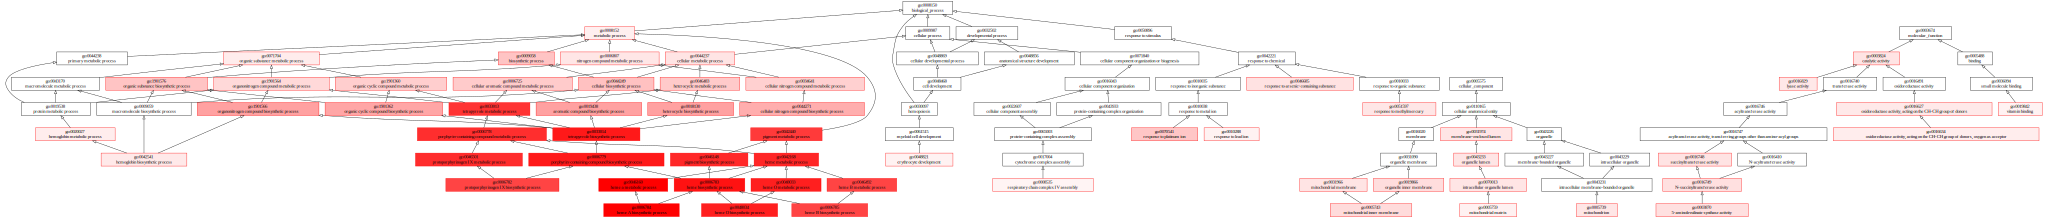

In [42]:
filteredGraph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
for currentGO in annotationsWithColors.index:
    #print(currentProtein)
    addAnnotationAncestors(currentGO, annotationsWithColors, filteredGraph)
filteredGraph

In [43]:
filteredGraph.format = "pdf"
filteredGraph.render("results/{}-reduced-threshold-0.05".format(setOfInterest))

'results/set1-reduced-threshold-0.05.pdf'